In [3]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import texttable as ttb
import latextable as lxtb

In [4]:
with open("database.json", "r") as f:
    dataset = json.load(f)

In [21]:
def correct_from_deltas(list_values):
    global counter, error, below
    vals = np.array(list_values)
    derniere_valeur = vals[-1]
    ite = np.arange(1, len(list_values) + 1)
    
    keep = [0]
    deltas = []
    for idx in range(1, len(vals)):
        delta = abs(vals[idx] - vals[idx - 1])
        if idx == 1:
            deltas.append(delta)
            keep.append(idx)
            continue
        if delta <= 3 * np.mean(deltas):
            deltas.append(delta)
            keep.append(idx)

    vals = vals[keep]
    ite = ite[keep]

    deg = 2
    if len(keep) <= 3:
        below += 1
        deg = 1
    coefs = np.polyfit(ite, vals, 1)
    trend = np.poly1d(coefs)

    
    ecarts = np.abs(vals - trend(ite))
    moy_ecarts = np.mean(ecarts)
    valeur_predite = trend(40)
    
    if np.abs(derniere_valeur - valeur_predite) > 3 * moy_ecarts:
        if valeur_predite > 4.5:
            error[0].append(f"{valeur_predite} p, {derniere_valeur}v")
        counter += 1
        return valeur_predite
    if derniere_valeur > 4.5:
        error[1].append(f"{derniere_valeur} v, {valeur_predite} p")
    return derniere_valeur

counter = 0
below = 0
error = [[], []]
data = {}
for model, cases in dataset.items():
    for ab, values in cases.items():
        if ab.split("/")[-1] not in data:
            data[ab.split("/")[-1]] = {}
        if model not in data[ab.split("/")[-1]]:
            data[ab.split("/")[-1]][model] = {
                "cl": [],
                "cd": [],
                "l/d": [],
                "cm": [],
                "cmx": [],
                "cmy": [],
                "cmz": [],
            }
        data[ab.split("/")[-1]][model]["cl"].append(correct_from_deltas(values["cl"]))
        data[ab.split("/")[-1]][model]["cd"].append(correct_from_deltas(values["cd"]))
        data[ab.split("/")[-1]][model]["l/d"].append(correct_from_deltas(values["l/d"]))
        
        cmx = correct_from_deltas(values["cmx"])
        cmy = correct_from_deltas(values["cmy"])
        cmz = correct_from_deltas(values["cmz"])
        data[ab.split("/")[-1]][model]["cmx"].append(cmx)
        data[ab.split("/")[-1]][model]["cmy"].append(cmy)
        data[ab.split("/")[-1]][model]["cmz"].append(cmz)
        data[ab.split("/")[-1]][model]["cm"].append(np.sqrt(cmx**2 + cmy**2 + cmz**2))

print(f"{counter} valeurs ont été corrigées, {len(error[0])}, {len(error[1])}")

870 valeurs ont été corrigées, 28, 198


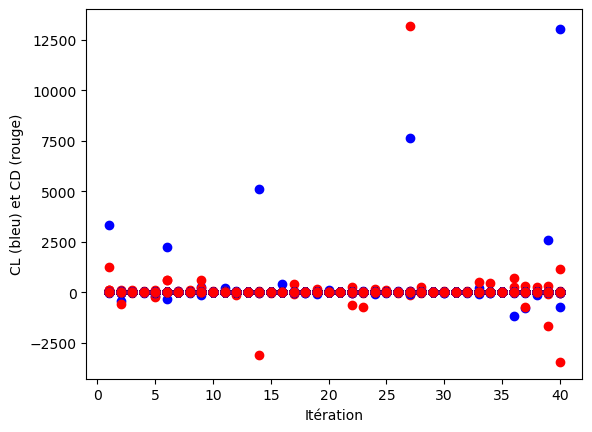

In [12]:

for model, cases in dataset.items():
    for ab, values in cases.items():
        cl_values = np.array(values["cl"])
        n = np.arange(1, len(cl_values)+1)
        plt.plot(n, cl_values, 'o', color="blue")
        plt.plot(n, np.array(values["cd"]), 'o', color="red")

plt.xlabel("Itération")
plt.ylabel("CL (bleu) et CD (rouge)")
#plt.legend()
plt.savefig("exemple_divergence_iterations3.png", dpi=600)
plt.show()

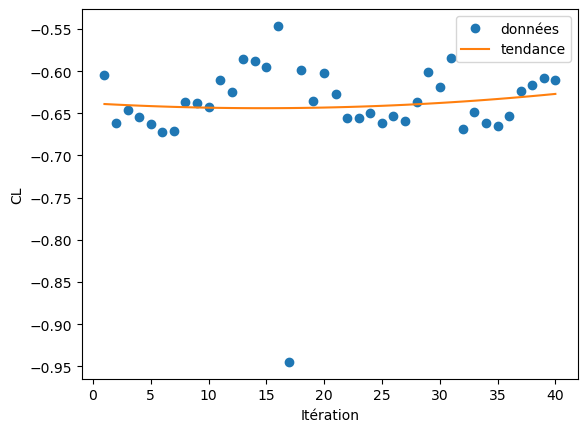

In [14]:
# Exemple : un cas
folder = "angle_0_TC_1"
case = "-10.0000000/0.0000000"
cl_values = np.array(dataset[folder][case]["cl"])

n = np.arange(1, len(cl_values)+1)
coefs = np.polyfit(n, cl_values, 2)
trend = np.poly1d(coefs)

plt.plot(n, cl_values, 'o', label="données")
plt.plot(n, trend(n), '-', label="tendance")
plt.xlabel("Itération")
plt.ylabel("CL")
plt.legend()
plt.savefig("exemple_divergence_iterations.png", dpi=600)
plt.show()

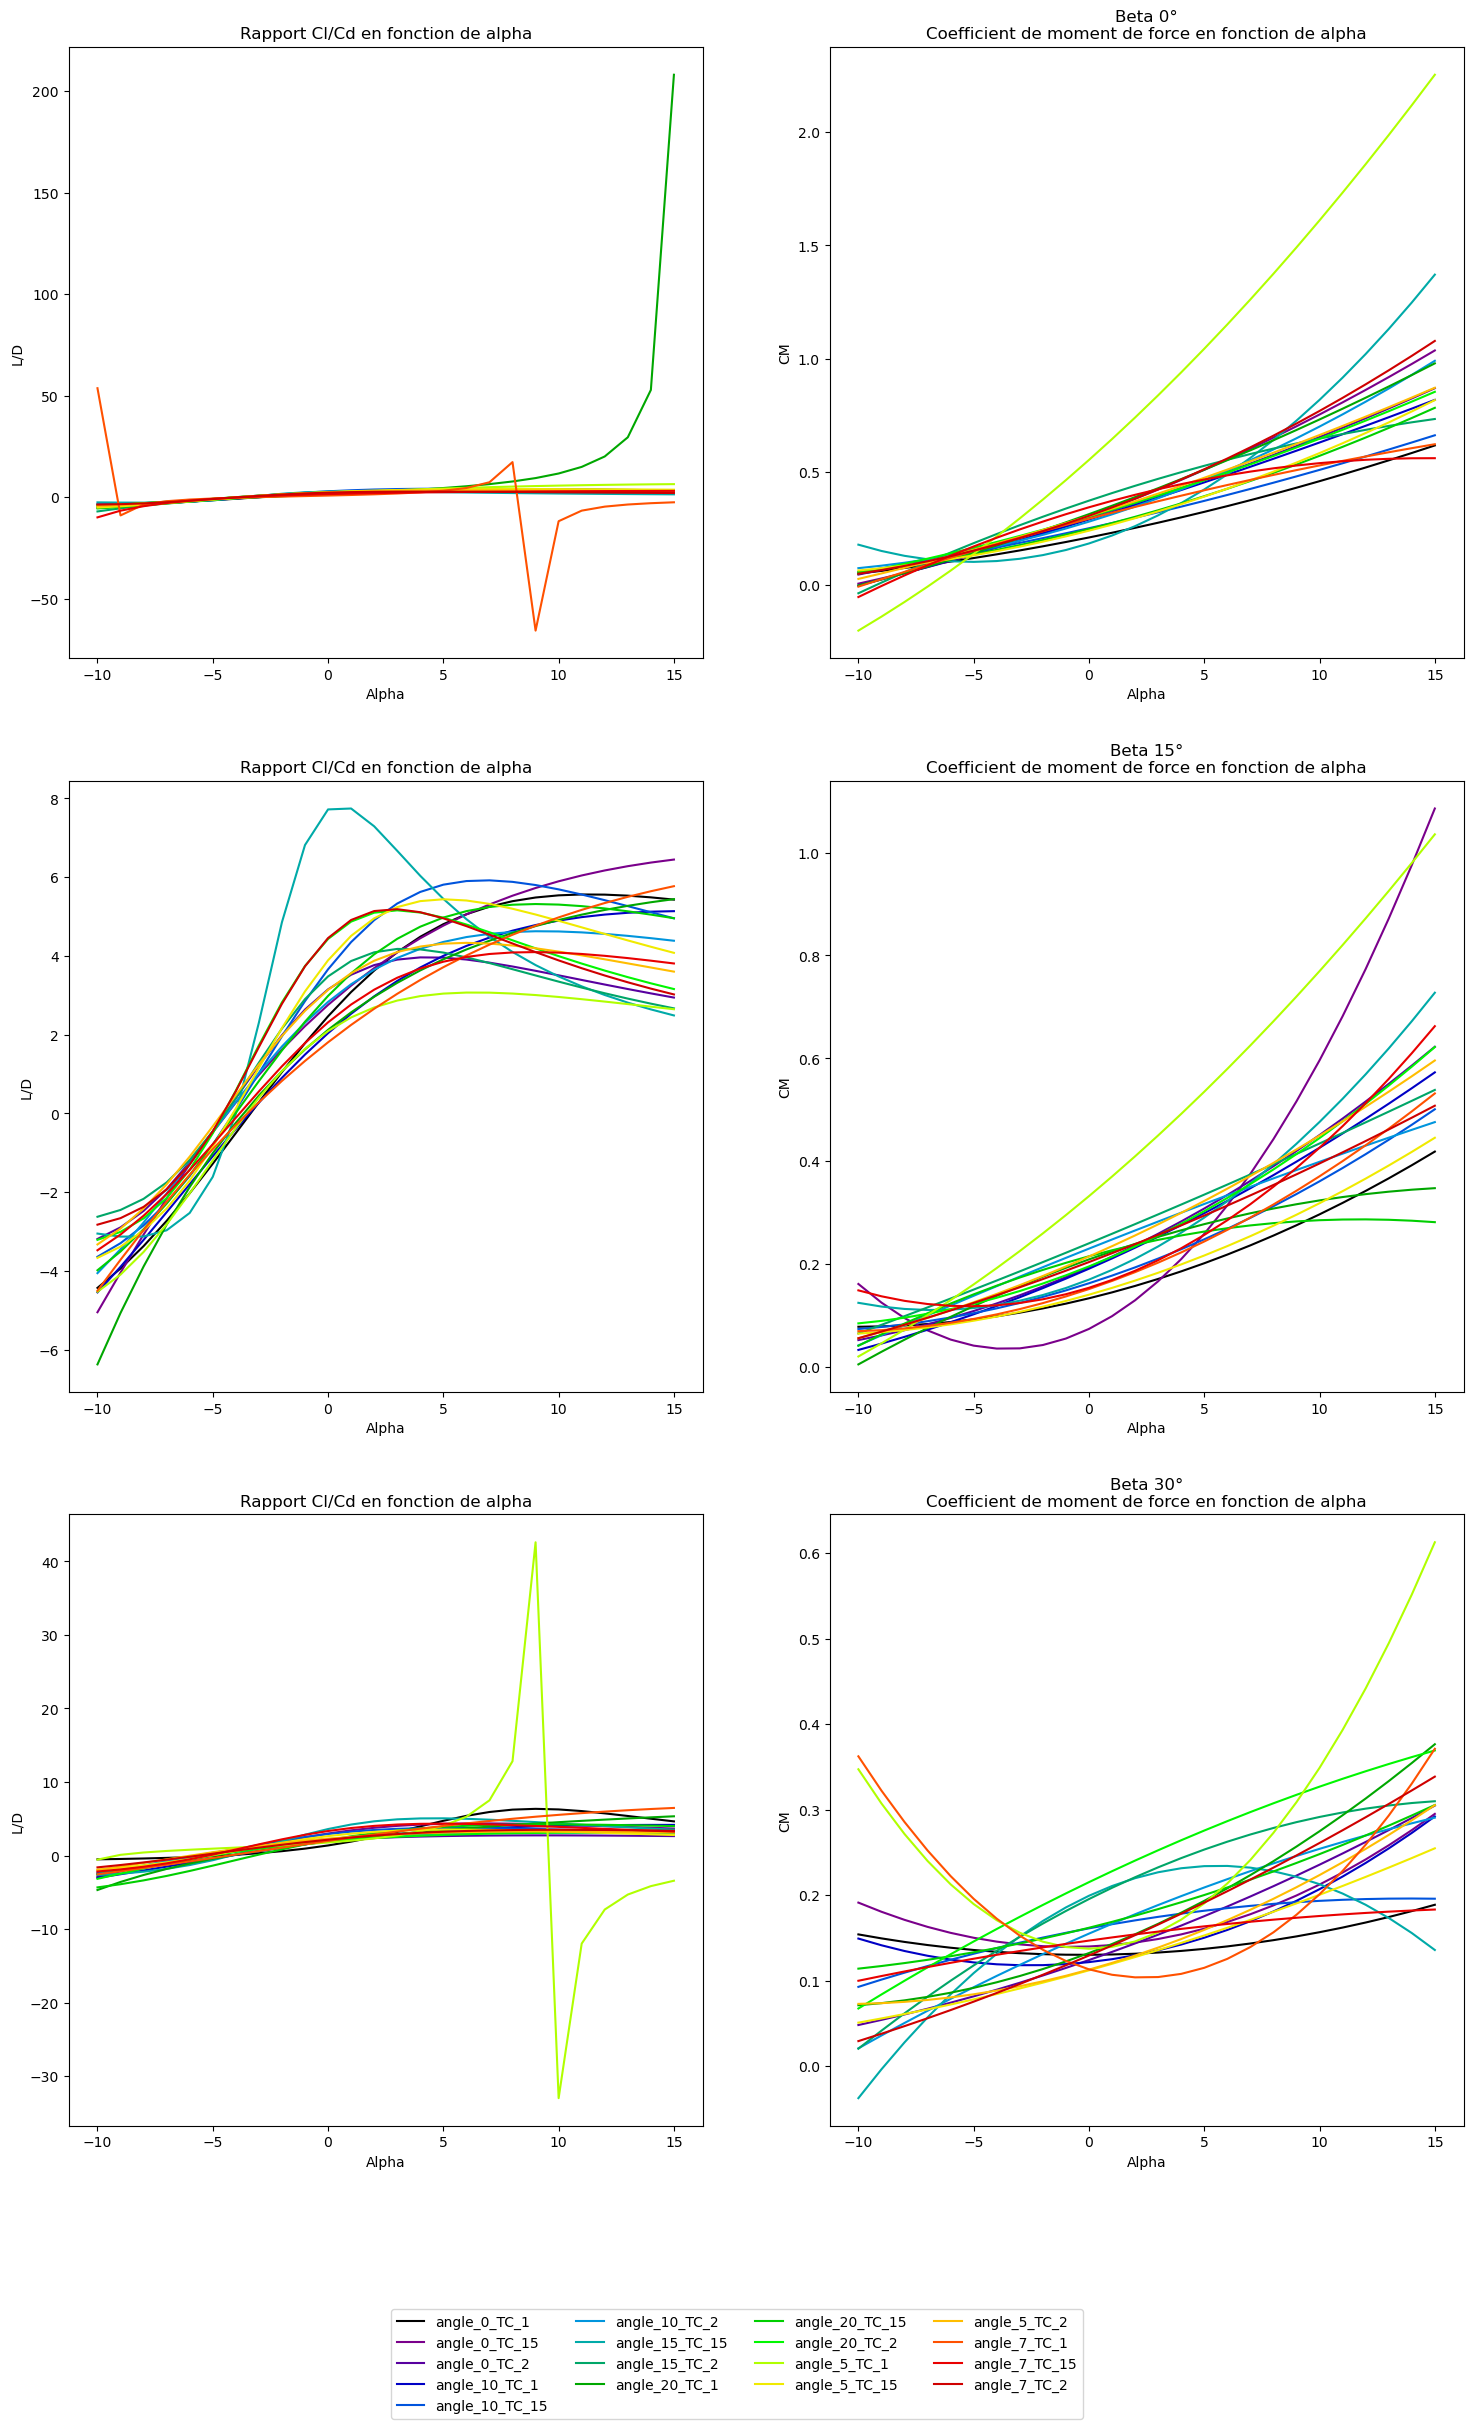

In [7]:
n_beta = 3
n_cols = 2  # On enlève la troisième colonne

fig, axes = plt.subplots(n_beta, n_cols, figsize=(18, 9 * n_beta))
models_list = list(next(iter(data.values())).keys())

cmap = plt.get_cmap('nipy_spectral')
colors = [cmap(i / len(models_list)) for i in range(len(models_list))]

for row, (beta, models) in enumerate(data.items()):
    for idx, (model, values) in enumerate(models.items()):
        alphas = np.arange(-10, 16)
        coefs_cl = np.polyfit(alphas, values["cl"], 1)
        coefs_cd = np.polyfit(alphas, values["cd"], 2)
        cl_fit = np.polyval(coefs_cl, alphas)
        cd_fit = np.polyval(coefs_cd, alphas)
        ld_fit = cl_fit / cd_fit   
        axes[row, 0].plot(alphas, ld_fit, label=f"{model}", color=colors[idx])
        axes[row, 0].set_xlabel("Alpha")
        axes[row, 0].set_ylabel("L/D")

        coefs = np.polyfit(alphas, values["cm"], 2)
        cm_fit = np.polyval(coefs, alphas)
        axes[row, 1].plot(alphas, cm_fit, label=f"{model}", color=colors[idx])
        axes[row, 1].set_xlabel("Alpha")
        axes[row, 1].set_ylabel("CM")
        axes[row, 0].set_title("\nRapport Cl/Cd en fonction de alpha")
        axes[row, 1].set_title(f"Beta {round(float(beta))}°\nCoefficient de moment de force en fonction de alpha")

fig.legend(models_list, loc="lower center", ncol=4)
plt.savefig("planche_beta1.png", dpi=700)
plt.show()


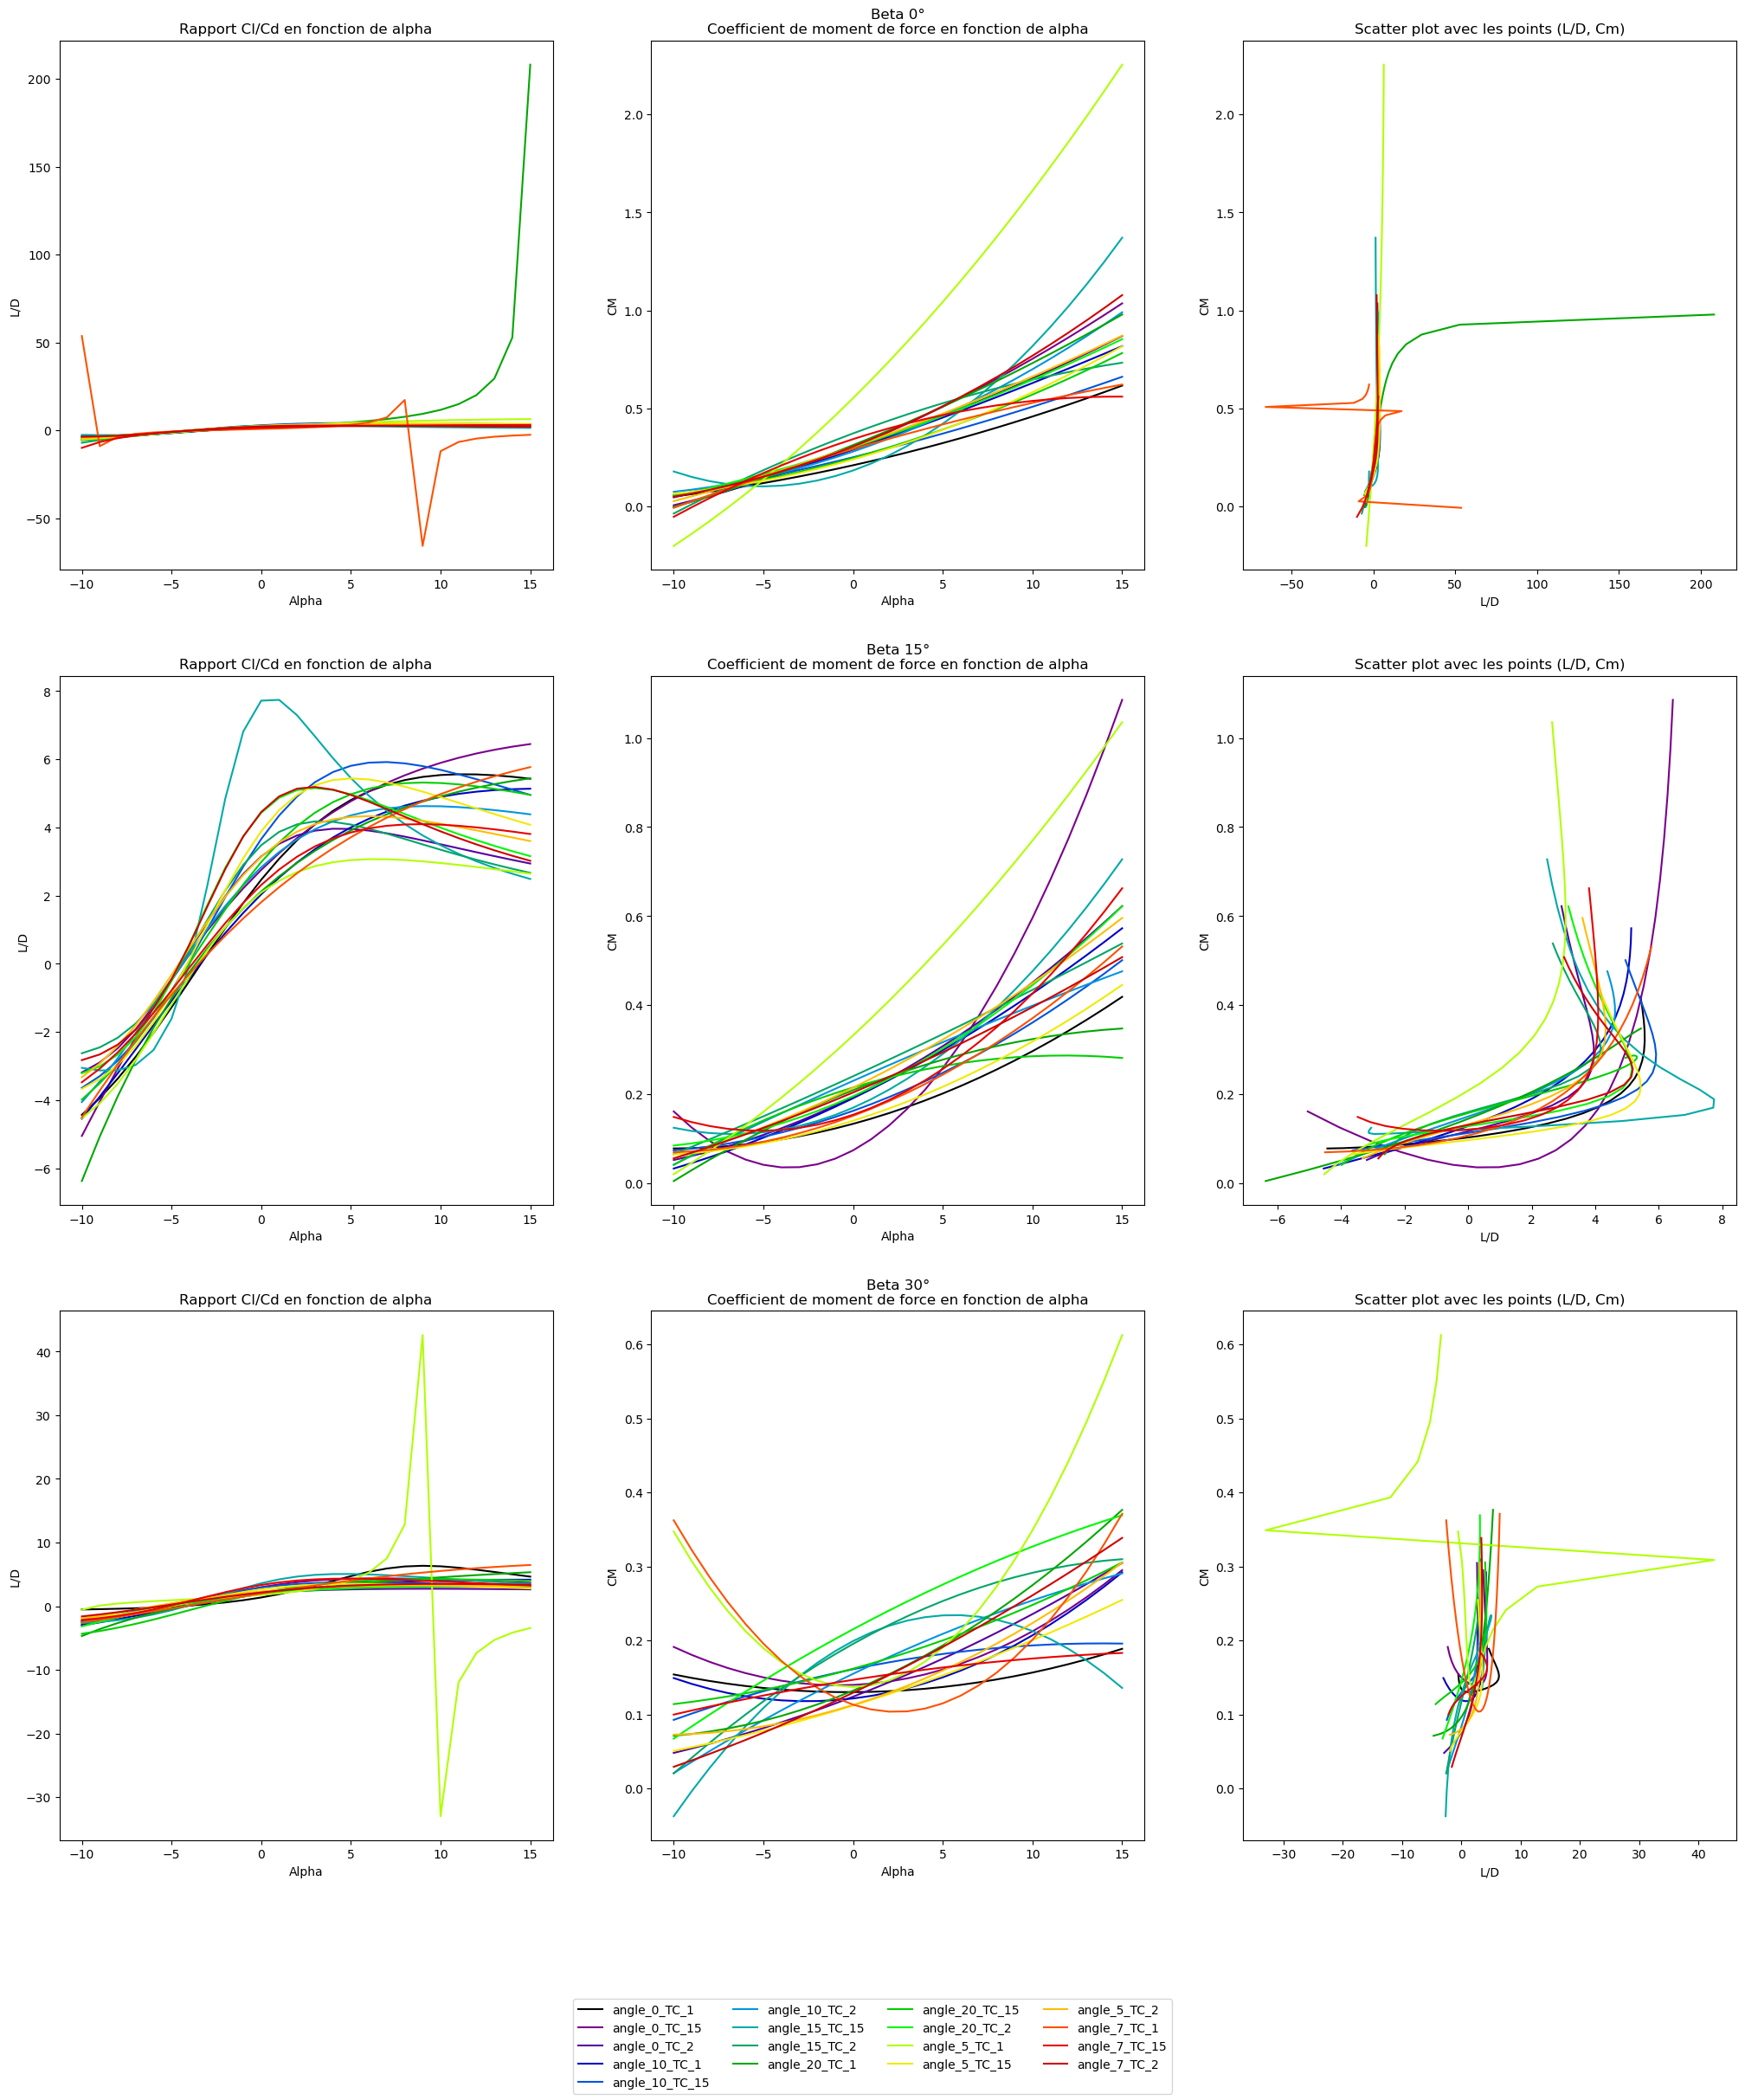

In [25]:
n_beta = 3
n_cols = 3

fig, axes = plt.subplots(n_beta, n_cols, figsize=(25, 9 * n_beta))
models_list = list(next(iter(data.values())).keys())

cmap = plt.get_cmap('nipy_spectral')
colors = [cmap(i / len(models_list)) for i in range(len(models_list))]

for row, (beta, models) in enumerate(data.items()):
    for idx, (model, values) in enumerate(models.items()):
        alphas = np.arange(-10, 16)
        coefs_cl = np.polyfit(alphas, values["cl"], 1)
        coefs_cd = np.polyfit(alphas, values["cd"], 2)
        cl_fit = np.polyval(coefs_cl, alphas)
        cd_fit = np.polyval(coefs_cd, alphas)
        ld_fit = cl_fit / cd_fit   
        axes[row, 0].plot(alphas, ld_fit, label=f"{model}", color=colors[idx])
        axes[row, 0].set_xlabel("Alpha")
        axes[row, 0].set_ylabel("L/D")

        coefs = np.polyfit(alphas, values["cm"], 2)
        cm_fit = np.polyval(coefs, alphas)
        axes[row, 1].plot(alphas, cm_fit, label=f"{model}", color=colors[idx])
        axes[row, 1].set_xlabel("Alpha")
        axes[row, 1].set_ylabel("CM")
        
        axes[row, 2].plot(ld_fit, cm_fit, label=f"{model}", color=colors[idx])
        axes[row, 2].set_xlabel("L/D")
        axes[row, 2].set_ylabel("CM")
        axes[row, 0].set_title("\nRapport Cl/Cd en fonction de alpha")
        axes[row, 1].set_title(f"Beta {round(float(beta))}°\nCoefficient de moment de force en fonction de alpha")
        axes[row, 2].set_title("\nScatter plot avec les points (L/D, Cm)")

fig.legend(models_list, loc="lower center", ncol=4)
plt.savefig("planche_beta.png", dpi=700)
plt.show()

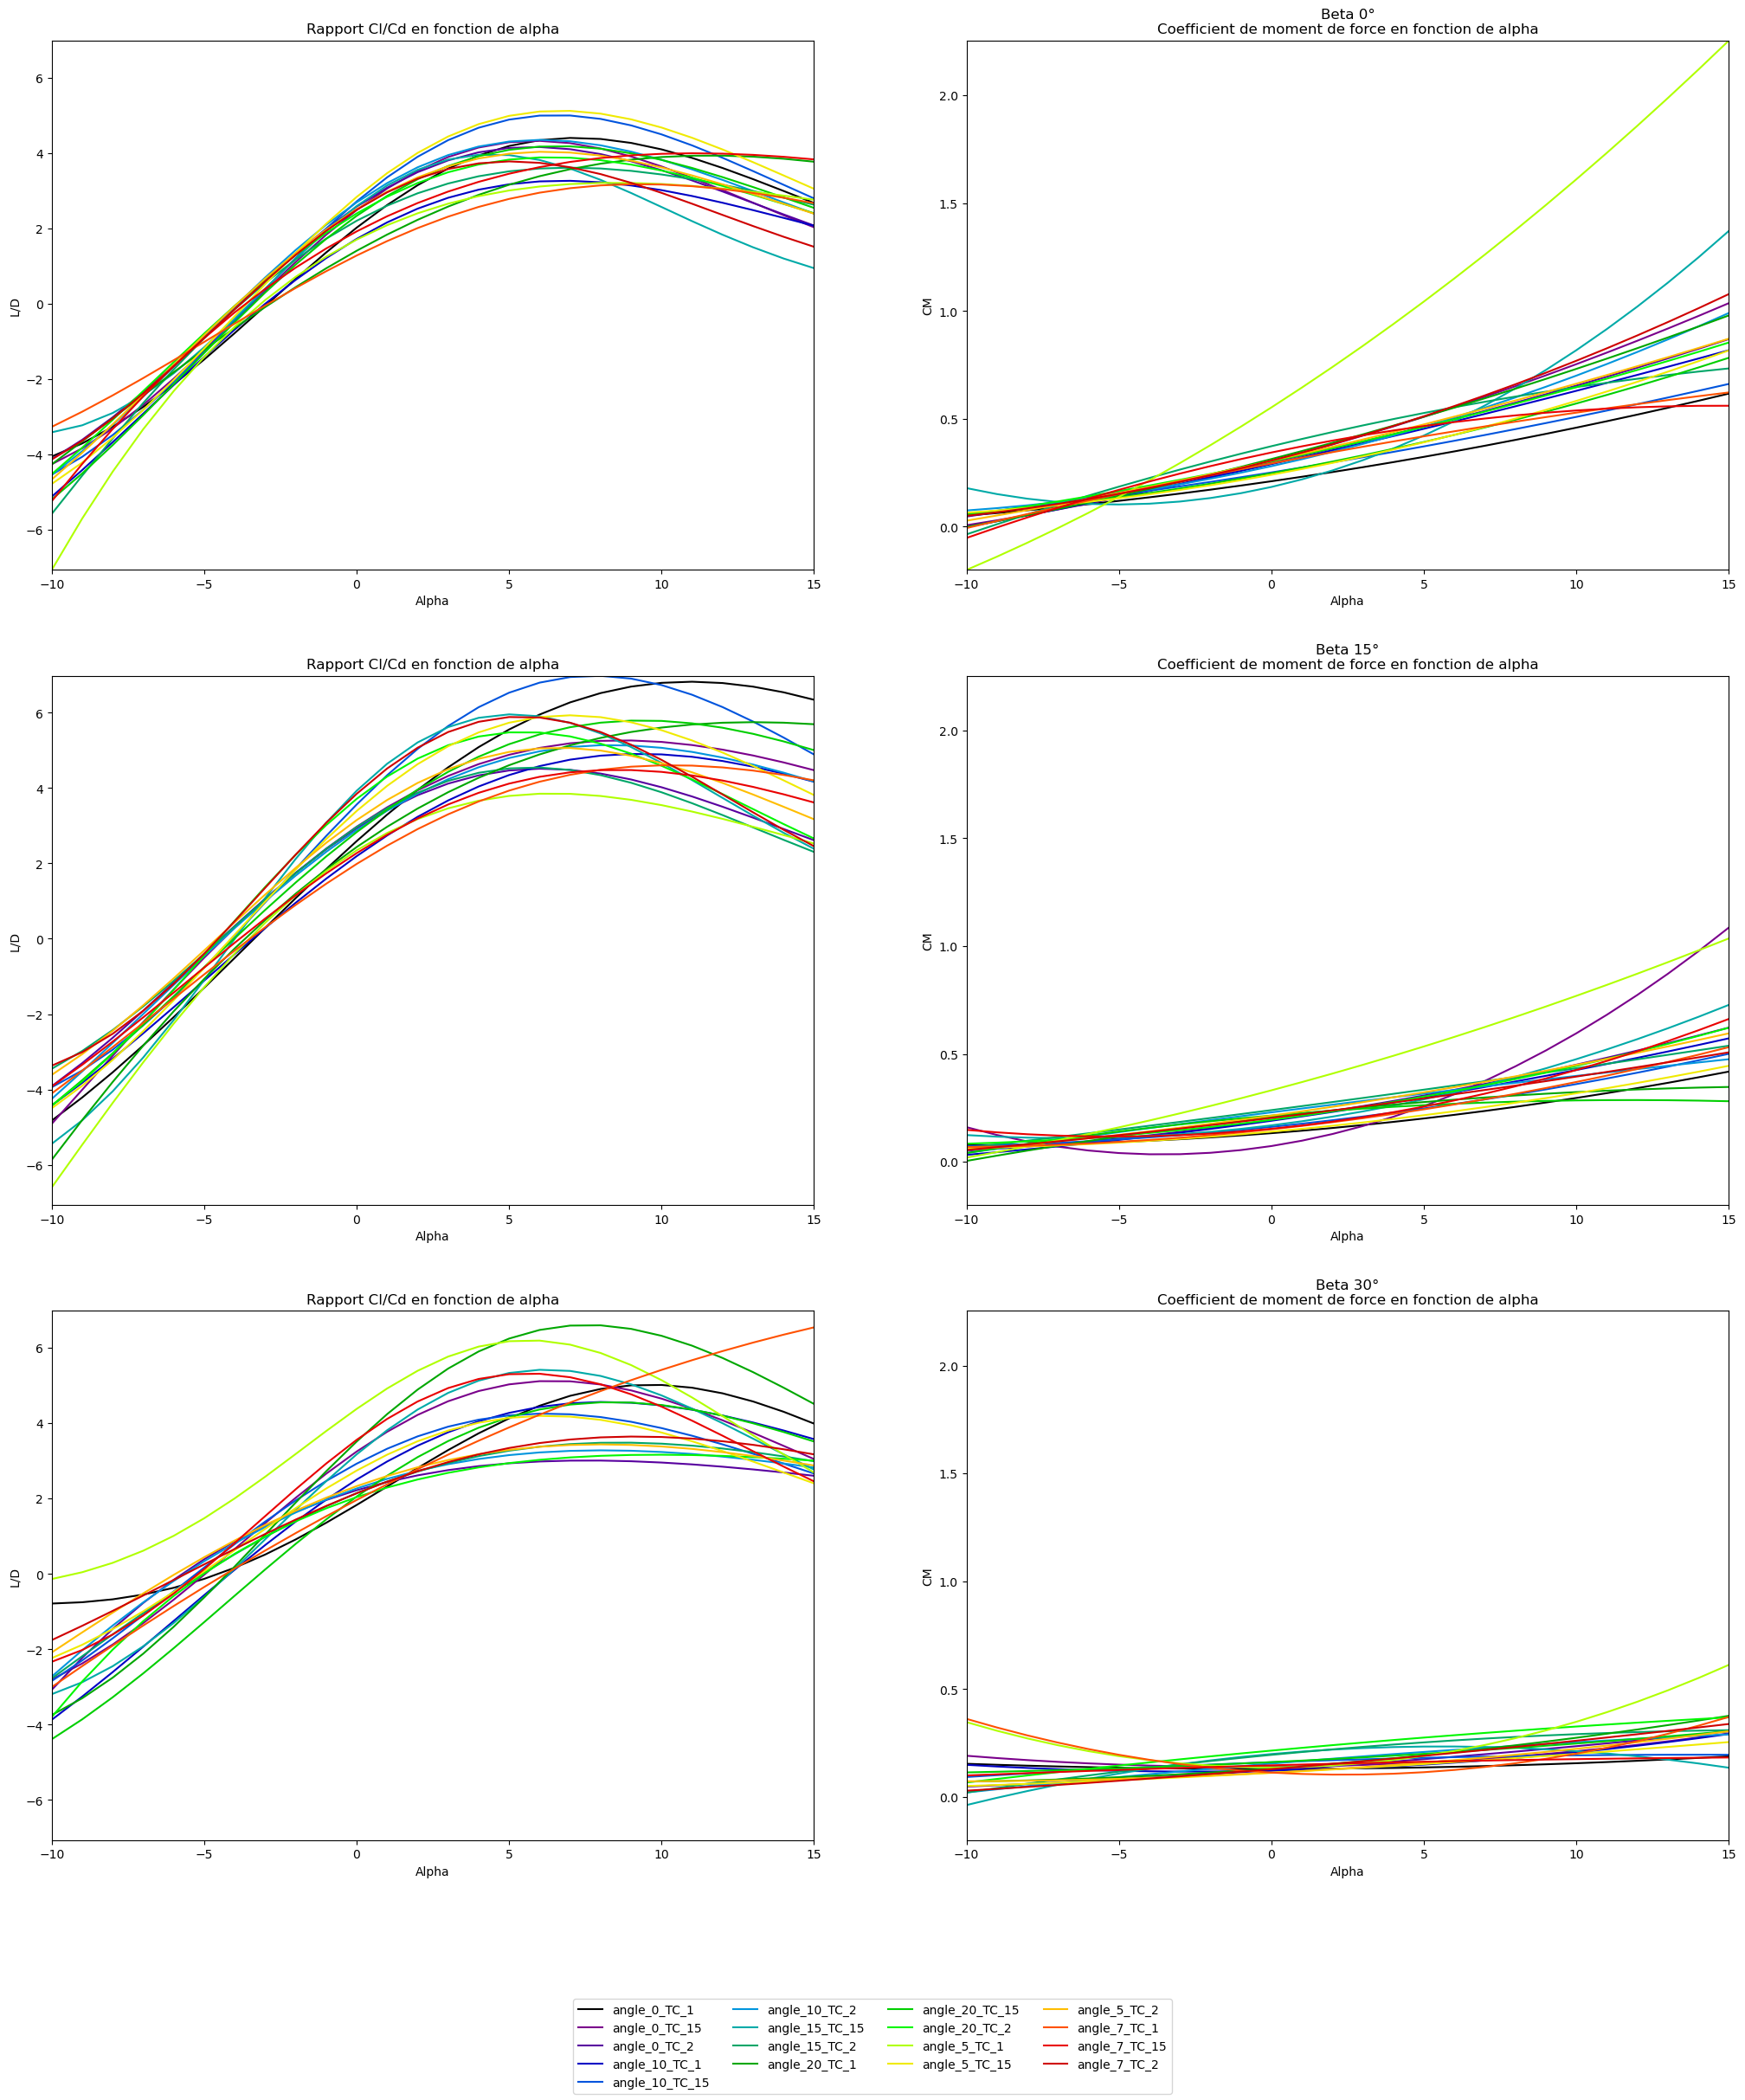

In [9]:
n_beta = 3
n_cols = 2

fig, axes = plt.subplots(n_beta, n_cols, figsize=(25, 9 * n_beta))
models_list = list(next(iter(data.values())).keys())

cmap = plt.get_cmap('nipy_spectral')
colors = [cmap(i / len(models_list)) for i in range(len(models_list))]

# Calcul des min/max pour tous les graphes
all_ld = []
all_cm = []

alphas = np.arange(-10, 16)

for beta, models in data.items():
    for model, values in models.items():
        coefs_cl = np.polyfit(alphas, values["cl"], 1)
        cl_fit = np.polyval(coefs_cl, alphas)

        cd_raw = np.asarray(values["cd"], dtype=float)
        bad = cd_raw <= 0
        if bad.any():
            cd_raw[bad] = np.interp(alphas[bad], alphas[~bad], cd_raw[~bad])
        coefs_logcd = np.polyfit(alphas, np.log(cd_raw), 2)
        cd_fit = np.exp(np.polyval(coefs_logcd, alphas))
        ld_fit = cl_fit / cd_fit

        coefs = np.polyfit(alphas, values["cm"], 2)
        cm_fit = np.polyval(coefs, alphas)

        all_ld.extend(ld_fit)
        all_cm.extend(cm_fit)

ld_min, ld_max = min(all_ld), max(all_ld)
cm_min, cm_max = min(all_cm), max(all_cm)

for row, (beta, models) in enumerate(data.items()):
    for idx, (model, values) in enumerate(models.items()):
        coefs_cl = np.polyfit(alphas, values["cl"], 1)
        cl_fit = np.polyval(coefs_cl, alphas)

        cd_raw = np.asarray(values["cd"], dtype=float)
        bad = cd_raw <= 0
        if bad.any():
            cd_raw[bad] = np.interp(alphas[bad], alphas[~bad], cd_raw[~bad])
        coefs_logcd = np.polyfit(alphas, np.log(cd_raw), 2)
        cd_fit = np.exp(np.polyval(coefs_logcd, alphas))
        ld_fit = cl_fit / cd_fit

        coefs = np.polyfit(alphas, values["cm"], 2)
        cm_fit = np.polyval(coefs, alphas)

        axes[row, 0].plot(alphas, ld_fit, label=f"{model}", color=colors[idx])
        axes[row, 0].set_xlabel("Alpha")
        axes[row, 0].set_ylabel("L/D")
        axes[row, 0].set_xlim(min(alphas), max(alphas))
        axes[row, 0].set_ylim(ld_min, ld_max)

        axes[row, 1].plot(alphas, cm_fit, label=f"{model}", color=colors[idx])
        axes[row, 1].set_xlabel("Alpha")
        axes[row, 1].set_ylabel("CM")
        axes[row, 1].set_xlim(min(alphas), max(alphas))
        axes[row, 1].set_ylim(cm_min, cm_max)

        axes[row, 0].set_title("\nRapport Cl/Cd en fonction de alpha")
        axes[row, 1].set_title(f"Beta {round(float(beta))}°\nCoefficient de moment de force en fonction de alpha")

fig.legend(models_list, loc="lower center", ncol=4)
plt.savefig("planche_betas_logarithmiques.png", dpi=700)
plt.show()


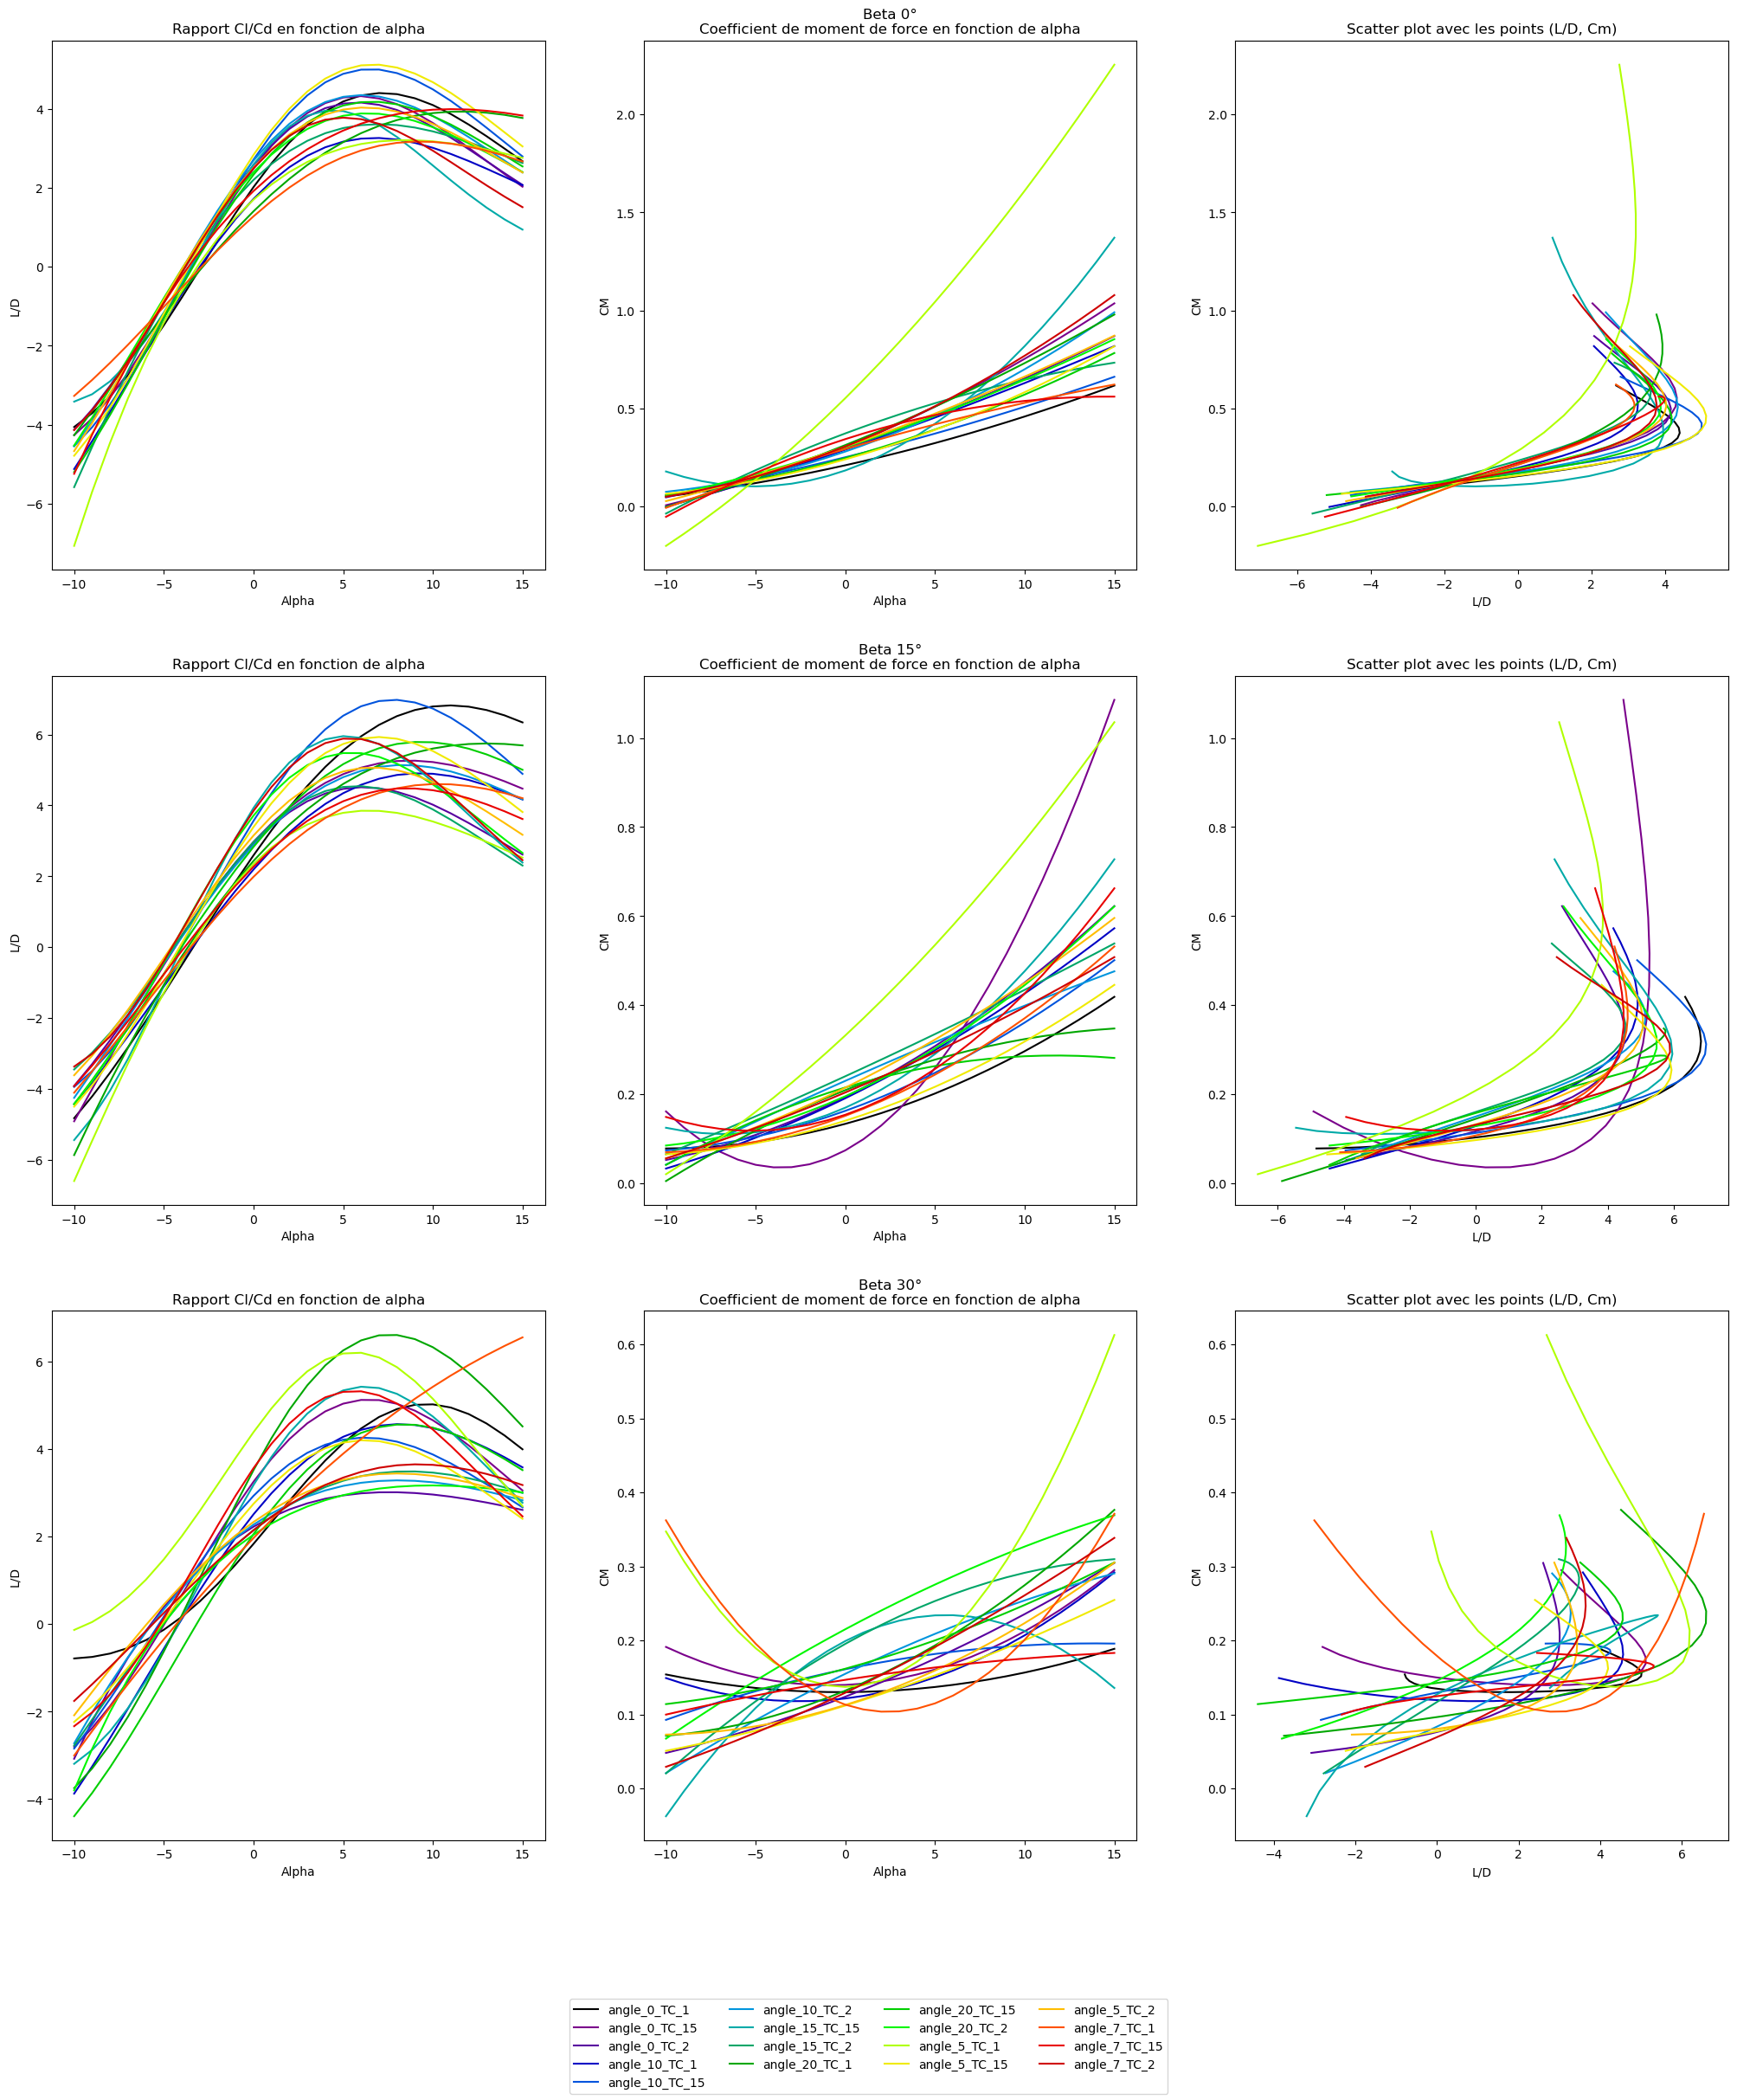

In [26]:

n_beta = 3
n_cols = 3

fig, axes = plt.subplots(n_beta, n_cols, figsize=(25, 9 * n_beta))
models_list = list(next(iter(data.values())).keys())

cmap = plt.get_cmap('nipy_spectral')
colors = [cmap(i / len(models_list)) for i in range(len(models_list))]

for row, (beta, models) in enumerate(data.items()):
    for idx, (model, values) in enumerate(models.items()):
        alphas = np.arange(-10, 16)

        coefs_cl = np.polyfit(alphas, values["cl"], 1)
        cl_fit = np.polyval(coefs_cl, alphas)

        cd_raw = np.asarray(values["cd"], dtype=float)
        bad = cd_raw <= 0
        if bad.any():
            cd_raw[bad] = np.interp(alphas[bad], alphas[~bad], cd_raw[~bad])
        coefs_logcd = np.polyfit(alphas, np.log(cd_raw), 2)
        cd_fit = np.exp(np.polyval(coefs_logcd, alphas))
        ld_fit = cl_fit / cd_fit

        axes[row, 0].plot(alphas, ld_fit, label=f"{model}", color=colors[idx])
        axes[row, 0].set_xlabel("Alpha")
        axes[row, 0].set_ylabel("L/D")

        coefs = np.polyfit(alphas, values["cm"], 2)
        cm_fit = np.polyval(coefs, alphas)
        axes[row, 1].plot(alphas, cm_fit, label=f"{model}", color=colors[idx])
        axes[row, 1].set_xlabel("Alpha")
        axes[row, 1].set_ylabel("CM")

        axes[row, 2].plot(ld_fit, cm_fit, label=f"{model}", color=colors[idx])
        axes[row, 2].set_xlabel("L/D")
        axes[row, 2].set_ylabel("CM")
        axes[row, 0].set_title("\nRapport Cl/Cd en fonction de alpha")
        axes[row, 1].set_title(f"Beta {round(float(beta))}°\nCoefficient de moment de force en fonction de alpha")
        axes[row, 2].set_title("\nScatter plot avec les points (L/D, Cm)")

fig.legend(models_list, loc="lower center", ncol=4)
plt.savefig("planche_betas_logarithmiques.png", dpi=700)
plt.show()

In [35]:

def draw_latex_table(table):
    ncol = len(table[0])
    latex = []
    latex.append(r"\begin{tabular}{" + "|l" + "|c"*(ncol-1) + "|}")
    latex.append(r"\hline")
    for i, row in enumerate(table):
        latex.append(" & ".join(str(cell) for cell in row) + r" \\")
        latex.append(r"\hline")
    latex.append(r"\end{tabular}")
    return "\n".join(latex)

def process_results(data):
    # Définition des colonnes
    table_data = [[
        "Modèle",
        r"$\int_{-10}^{15} L/D(\alpha) d\alpha [\beta=0,15,30]$",
        r"$\int_{-10}^{15} CM'(\alpha) d\alpha [\beta=0,15,30]$",
        r"$\int_{-10}^{15} CM_x'(\alpha) d\alpha [\beta=0,15,30]$",
        r"$\int_{-10}^{15} CM_y'(\alpha) d\alpha [\beta=0,15,30]$",
        r"$\int_{-10}^{15} CM_z'(\alpha) d\alpha [\beta=0,15,30]$",
        "position globale moyenne"
    ]]

    all_models = sorted({m for models in data.values() for m in models})
    all_betas = sorted({int(float(b)) for b in data.keys()})

    dico = {}
    for beta, models in data.items():
        beta = int(float(beta))
        results = []
        for model, values in models.items():
            alphas = np.arange(-10, 16)

            # Fit Cl
            coefs_cl = np.polyfit(alphas, values["cl"], 1)
            cl_fit = np.polyval(coefs_cl, alphas)

            # Fit Cd (log)
            cd_raw = np.asarray(values["cd"], dtype=float)
            bad = cd_raw <= 0
            if bad.any():
                cd_raw[bad] = np.interp(alphas[bad], alphas[~bad], cd_raw[~bad])
            coefs_logcd = np.polyfit(alphas, np.log(cd_raw), 2)
            cd_fit = np.exp(np.polyval(coefs_logcd, alphas))

            # L/D intégrale
            ld_int = np.trapezoid(cl_fit / cd_fit, alphas)

            # Intégrales dérivées pour CM, CMx, CMy, CMz
            def deriv_int(y):
                coefs = np.polyfit(alphas, values[y], 2)
                coefs_der = np.polyder(coefs)
                return np.trapezoid(np.polyval(coefs_der, alphas), alphas)

            cm_der_int = deriv_int("cm")
            cmx_der_int = deriv_int("cmx")
            cmy_der_int = deriv_int("cmy")
            cmz_der_int = deriv_int("cmz")

            results.append((model, ld_int, cm_der_int, cmx_der_int, cmy_der_int, cmz_der_int))

        # Classement local par beta
        results_sorted = sorted(results, key=lambda r: (-r[1], r[2], r[3], r[4], r[5]))
        for pos, vals in enumerate(results_sorted, start=1):
            model, ld_int, cm_der_int, cmx_int, cmy_int, cmz_int = vals
            dico.setdefault(model, {}).setdefault(beta, {})["ld"] = round(ld_int, 2)
            dico[model][beta]["cm"] = round(cm_der_int, 2)
            dico[model][beta]["cmx"] = round(cmx_int, 2)
            dico[model][beta]["cmy"] = round(cmy_int, 2)
            dico[model][beta]["cmz"] = round(cmz_int, 2)
            dico[model][beta]["pos"] = pos
            
    for model in all_models:
        row = [model.replace("_", r"\_")]
    
        def safe_sum(key):
            vals = [dico.get(model, {}).get(b, {}).get(key, None) for b in all_betas]
            vals = [v for v in vals if isinstance(v, (int, float))]
            return round(sum(vals), 2) if vals else ""
    
        # L/D somme sur betas
        row.append(safe_sum("ld"))
        # CM somme
        row.append(safe_sum("cm"))
        # CMx somme
        row.append(safe_sum("cmx"))
        # CMy somme
        row.append(safe_sum("cmy"))
        # CMz somme
        row.append(safe_sum("cmz"))
    
        # Position globale moyenne (rang moyen)
        pos_values = [dico.get(model, {}).get(b, {}).get("pos") for b in all_betas if "pos" in dico.get(model, {}).get(b, {})]
        avg_pos = round(sum(pos_values)/len(pos_values), 1) if pos_values else ""
        row.append(avg_pos)
        table_data.append(row)

    # Tri par le score global moyen
    table_data = [table_data[0]] + sorted(table_data[1:], key=lambda r: (r[-1] if r[-1] != "" else 9999))

    print(draw_latex_table(table_data))
process_results(data)

\begin{tabular}{|l|c|c|c|c|c|c|}
\hline
Modèle & $\int_{-10}^{15} L/D(\alpha) d\alpha [\beta=0,15,30]$ & $\int_{-10}^{15} CM'(\alpha) d\alpha [\beta=0,15,30]$ & $\int_{-10}^{15} CM_x'(\alpha) d\alpha [\beta=0,15,30]$ & $\int_{-10}^{15} CM_y'(\alpha) d\alpha [\beta=0,15,30]$ & $\int_{-10}^{15} CM_z'(\alpha) d\alpha [\beta=0,15,30]$ & position globale moyenne \\
\hline
angle\_10\_TC\_15 & 192.64 & 1.13 & 0.04 & 1.36 & -0.01 & 3.7 \\
\hline
angle\_5\_TC\_15 & 178.71 & 1.33 & 0.04 & 1.38 & -0.01 & 4.3 \\
\hline
angle\_0\_TC\_1 & 178.34 & 0.94 & 0.08 & 0.96 & 0.06 & 5.0 \\
\hline
angle\_0\_TC\_15 & 172.29 & 2.06 & 0.04 & 1.29 & -0.01 & 6.0 \\
\hline
angle\_10\_TC\_2 & 156.07 & 1.62 & 0.04 & 1.69 & -0.01 & 8.0 \\
\hline
angle\_20\_TC\_1 & 176.86 & 1.63 & -0.04 & 0.77 & 0.26 & 8.3 \\
\hline
angle\_5\_TC\_2 & 156.02 & 1.61 & 0.03 & 1.7 & -0.01 & 8.7 \\
\hline
angle\_7\_TC\_2 & 157.29 & 1.79 & 0.03 & 1.78 & 0.04 & 8.7 \\
\hline
angle\_7\_TC\_15 & 160.6 & 1.2 & 0.05 & 1.57 & -0.01 & 9.0 \\
\hlin

In [38]:

def draw_latex_table(table):
    ncol = len(table[0])
    latex = []
    latex.append(r"\begin{tabular}{" + "|l" + "|c"*(ncol-1) + "|}")
    latex.append(r"\hline")
    for i, row in enumerate(table):
        latex.append(" & ".join(str(cell) for cell in row) + r" \\")
        latex.append(r"\hline")
    latex.append(r"\end{tabular}")
    return "\n".join(latex)

def process_results(data):
    table_topscore = [
        ["Modèle", r"$\int_{-10}^{15} L/D(\alpha) d \alpha$", r"$\int_{-10}^{15} CM(\alpha) d \alpha$", "position global"],
    ]
    results = []
    all_results = []
    for beta, models in data.items():
        for model, values in models.items():
            alphas = np.arange(-10, 16)

            # 1 fit de Cl
            coefs_cl = np.polyfit(alphas, values["cl"], 1)
            cl_fit = np.polyval(coefs_cl, alphas)

            # 2 fit de Cd, soit log(Cd) pour forcer Cd > 0 
            cd_raw = np.asarray(values["cd"], dtype=float)
            bad = cd_raw <= 0
            if bad.any():
                cd_raw[bad] = np.interp(alphas[bad], alphas[~bad], cd_raw[~bad])
            coefs_logcd = np.polyfit(alphas, np.log(cd_raw), 2)
            cd_fit = np.exp(np.polyval(coefs_logcd, alphas))
                
            # 3 L/D sans asymptotes
            ld_fit = cl_fit / cd_fit
            ld_int = np.trapezoid(ld_fit, alphas)
            
            coefs_cm = np.polyfit(alphas, values["cm"], 2)
            coefs_cm_der = np.polyder(coefs_cm)
            cm_der_fit = np.polyval(coefs_cm_der, alphas)
            cm_der_int = np.trapezoid(cm_der_fit, alphas)
            
            results.append((model, ld_int, cm_der_int, int(float(beta))))
        
        results_sorted = sorted(results, key=lambda r: (-r[1], r[2]))
        all_results.append(results_sorted)
        results = []

    # 1. Collecte des modèles et betas disponibles
    all_models = set()
    all_betas = set()
    for beta, models in data.items():
        all_betas.add(int(float(beta)))
        for model in models:
            all_models.add(model)
    all_betas = sorted(list(all_betas))  # [0, 15, 30]
    all_models = sorted(list(all_models))

    # 2. Construction du tableau
    table_data = [
        [
            "Modèle",
            *(rf"$\int_{{-10}}^{{15}} L/D(\alpha) d\alpha$ (beta {b}°)" for b in all_betas),
            *(rf"$\int_{{-10}}^{{15}} CM(\alpha) d\alpha$ (beta {b}°)" for b in all_betas),
            *(f"position beta {b}°" for b in all_betas),
        ]
    ]

    dico = {}
    for beta, models in data.items():
        results = []
        for model, values in models.items():
            alphas = np.arange(-10, 16)
            coefs_cl = np.polyfit(alphas, values["cl"], 1)
            cl_fit = np.polyval(coefs_cl, alphas)
            cd_raw = np.asarray(values["cd"], dtype=float)
            bad = cd_raw <= 0
            if bad.any():
                cd_raw[bad] = np.interp(alphas[bad], alphas[~bad], cd_raw[~bad])
            coefs_logcd = np.polyfit(alphas, np.log(cd_raw), 2)
            cd_fit = np.exp(np.polyval(coefs_logcd, alphas))
            ld_fit = cl_fit / cd_fit
            ld_int = np.trapezoid(ld_fit, alphas)
            coefs_cm = np.polyfit(alphas, values["cm"], 2)
            coefs_cm_der = np.polyder(coefs_cm)
            cm_der_fit = np.polyval(coefs_cm_der, alphas)
            cm_der_int = np.trapezoid(cm_der_fit, alphas)
            results.append((model, ld_int, cm_der_int, int(float(beta))))
        results_sorted = sorted(results, key=lambda r: (-r[1], r[2]))
        for position, values in enumerate(results_sorted):
            model, ld_int, cm_der_int, beta = values
            dico[(model, int(beta))] = (round(ld_int, 2), round(cm_der_int, 2), position+1)

    # Génération des lignes du tableau
    for model in all_models:
        row = [model.replace("_", r"\_")]
        for b in all_betas:
            row.append(dico.get((model, b), ("", "", ""))[0])
        for b in all_betas:
            row.append(dico.get((model, b), ("", "", ""))[1])
        for b in all_betas:
            row.append(dico.get((model, b), ("", "", ""))[2])
        table_data.append(row)

    # Génération du tableau LaTeX
    flat_results = [item for sublist in all_results for item in sublist]
    combined_results = []
    for r in flat_results:
        model, ld_int, cm_der_int, beta = r
        found = False
        for i, entry in enumerate(combined_results):
            if entry[0] == model:
                combined_results[i][1].append(ld_int)
                combined_results[i][2].append(cm_der_int)
                found = True
                break
        if not found:
            combined_results.append([model, [ld_int], [cm_der_int]])
            
    final_results = []
    for model, ld_list, cm_list in combined_results:
        ld_avg = sum(ld_list)/len(ld_list)
        cm_avg = sum(cm_list)/len(cm_list)
        final_results.append((model, ld_avg, cm_avg))

    final_results_sorted = sorted(final_results, key=lambda r: (-r[1], r[2]))

    for position, values in enumerate(final_results_sorted[:10]):
        model, ld_avg, cm_avg = values
        table_topscore.append([model.replace("_", r"\_"), round(ld_avg, 2), round(cm_avg, 2), position+1])

    t_all = ttb.Texttable()
    t_all.add_rows(table_data)
    t_top = ttb.Texttable()
    t_top.add_rows(table_topscore)

    print(t_all.draw())
    print(t_top.draw())
    print(draw_latex_table(table_data))
    print(draw_latex_table(table_topscore))

process_results(data)

+-------+-------+-------+-------+-------+-------+-------+-------+-------+------+
| Modèl | $\int | $\int | $\int | $\int | $\int | $\int | posit | posit | posi |
|   e   |  _{-  |  _{-  |  _{-  |  _{-  |  _{-  |  _{-  |  ion  |  ion  | tion |
|       | 10}^{ | 10}^{ | 10}^{ | 10}^{ | 10}^{ | 10}^{ | beta  | beta  | beta |
|       | 15} L | 15} L | 15} L | 15} C | 15} C | 15} C |  0°   |  15°  | 30°  |
|       | /D(\a | /D(\a | /D(\a | M(\al | M(\al | M(\al |       |       |      |
|       | lpha) | lpha) | lpha) | pha)  | pha)  | pha)  |       |       |      |
|       | d\alp | d\alp | d\alp | d\alp | d\alp | d\alp |       |       |      |
|       |  ha$  |  ha$  |  ha$  |  ha$  |  ha$  |  ha$  |       |       |      |
|       | (beta | (beta | (beta | (beta | (beta | (beta |       |       |      |
|       |  0°)  | 15°)  | 30°)  |  0°)  | 15°)  | 30°)  |       |       |      |
+=======+=======+=======+=======+=======+=======+=======+=======+=======+======+
| angle | 41.82 | 73.60 | 62

In [32]:
table_data = [
    ["Modèle", "Beta (degré °)", r"$\int_{-10}^{15} L/D(\alpha) d \alpha$", r"$\int_{-10}^{15} CM(\alpha) d \alpha$", "position pour son Beta"],
]
table_topscore = [
    ["Modèle", r"$\int_{-10}^{15} L/D(\alpha) d \alpha$", r"$\int_{-10}^{15} CM(\alpha) d \alpha$", "position global"],
]
results = []
all_results = []
for beta, models in data.items():
    for model, values in models.items():
        alphas = np.arange(-10, 16)

        # 1 fit de Cl
        coefs_cl = np.polyfit(alphas, values["cl"], 1)
        cl_fit = np.polyval(coefs_cl, alphas)

        # 2 fit de Cd, soit log(Cd) pour forcer Cd > 0 
        cd_raw = np.asarray(values["cd"], dtype=float)
        # On a des valeurs Cd <= 0 donc remplace petite valeur positive
        bad = cd_raw <= 0
        if bad.any():
            cd_raw[bad] = np.interp(alphas[bad], alphas[~bad], cd_raw[~bad])
        coefs_logcd = np.polyfit(alphas, np.log(cd_raw), 2)
        cd_fit = np.exp(np.polyval(coefs_logcd, alphas))
            
        # 3 L/D sans asymptotes
        ld_fit = cl_fit / cd_fit
        ld_int = np.trapezoid(ld_fit, alphas)
        
        coefs_cm = np.polyfit(alphas, values["cm"], 2)
        coefs_cm_der = np.polyder(coefs_cm)
        cm_der_fit = np.polyval(coefs_cm_der, alphas)
        cm_der_int = np.trapezoid(cm_der_fit, alphas)
        
        results.append((model, ld_int, cm_der_int, beta))
        
    results_sorted = sorted(results, key=lambda r: (-r[1], r[2]))
    all_results.append(results_sorted)
    for position, values in enumerate(results_sorted):
        table_data.append([values[0], round(float(beta)), round(values[1], 2), round(values[2], 2), position+1])

flat_results = [item for sublist in all_results for item in sublist]
combined_results = []
for r in flat_results:
    model, ld_int, cm_der_int, beta = r
    found = False
    for i, entry in enumerate(combined_results):
        if entry[0] == model:
            combined_results[i][1].append(ld_int)
            combined_results[i][2].append(cm_der_int)
            found = True
            break
    if not found:
        combined_results.append([model, [ld_int], [cm_der_int]])
        
final_results = []
for model, ld_list, cm_list in combined_results:
    ld_avg = sum(ld_list)/len(ld_list)
    cm_avg = sum(cm_list)/len(cm_list)
    final_results.append((model, ld_avg, cm_avg))

final_results_sorted = sorted(final_results, key=lambda r: (-r[1], r[2]))

for position, values in enumerate(final_results_sorted[:10]):
    model, ld_avg, cm_avg = values
    table_topscore.append([model.replace("_", "\_"), round(ld_avg, 2), round(cm_avg, 2), position+1])

t_all = ttb.Texttable()
t_all.add_rows(table_data)
t_top = ttb.Texttable()
t_top.add_rows(table_topscore)
print(t_all.draw())
print(t_top.draw())
print(lxtb.draw_latex(table_data))
print(lxtb.draw_latex(table_topscore))

+---------------+---------------+---------------+---------------+--------------+
|    Modèle     |  Beta (degré  |   $\int_{-    |   $\int_{-    |   position   |
|               |      °)       |   10}^{15}    |   10}^{15}    |   pour son   |
|               |               | L/D(\alpha) d | CM(\alpha) d  |     Beta     |
|               |               |    \alpha$    |    \alpha$    |              |
+===============+===============+===============+===============+==============+
| angle_5_TC_15 | 0             | 53.890        | 0.750         | 1            |
+---------------+---------------+---------------+---------------+--------------+
| angle_10_TC_1 | 0             | 51.230        | 0.600         | 2            |
| 5             |               |               |               |              |
+---------------+---------------+---------------+---------------+--------------+
| angle_10_TC_2 | 0             | 46.020        | 0.920         | 3            |
+---------------+-----------

<>:66: SyntaxWarning: invalid escape sequence '\_'
<>:66: SyntaxWarning: invalid escape sequence '\_'
C:\Users\arthur\AppData\Local\Temp\ipykernel_3008\134667352.py:66: SyntaxWarning: invalid escape sequence '\_'
  table_topscore.append([model.replace("_", "\_"), round(ld_avg, 2), round(cm_avg, 2), position+1])


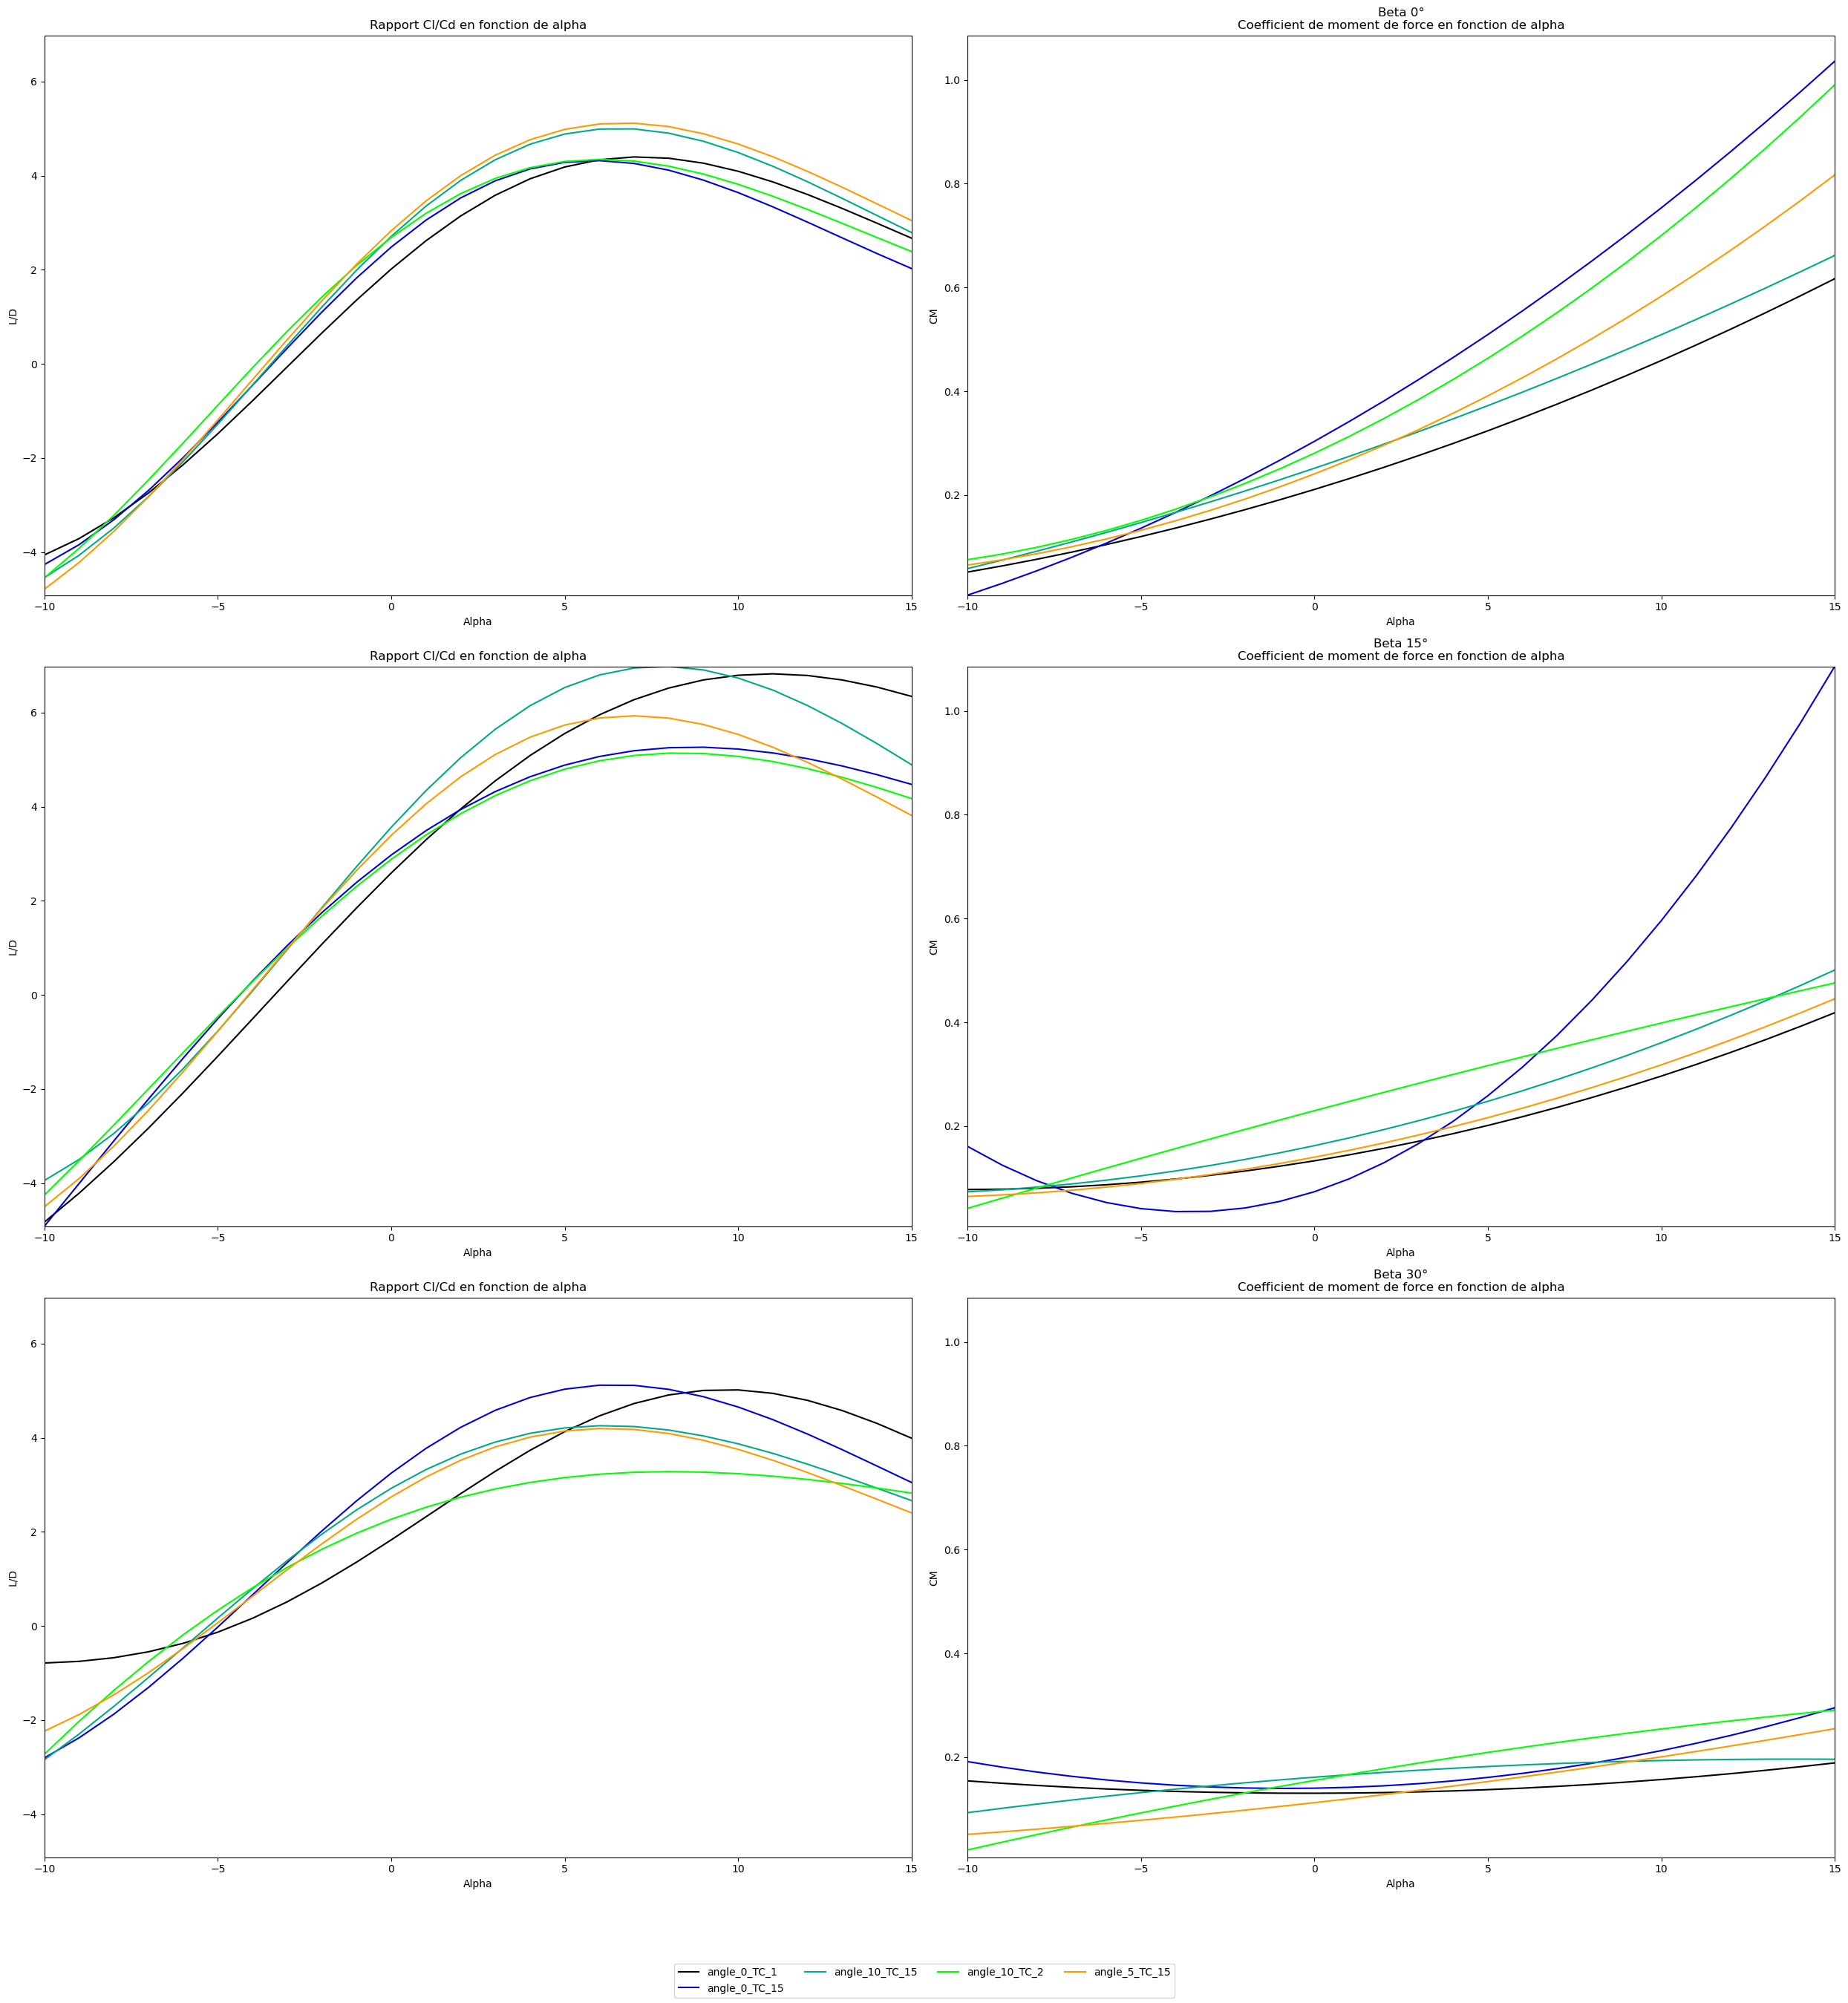

In [14]:
n_beta = 3
n_cols = 2  # Changed from 3 to 2 to remove the third column

fig, axes = plt.subplots(n_beta, n_cols, figsize=(25, 9 * n_beta))
wanted_models = ["angle_10_TC_15", "angle_5_TC_15", "angle_0_TC_1", "angle_0_TC_15", "angle_10_TC_2"]
all_models = list(next(iter(data.values())).keys())
models_list = [m for m in all_models if m in wanted_models]

cmap = plt.get_cmap('nipy_spectral')
colors = [cmap(i / len(models_list)) for i in range(len(models_list))]

# Precompute global axis limits to use consistent scales
all_alphas = np.arange(-10, 16)
all_ld_vals = []
all_cm_vals = []

for beta, models in data.items():
    for model, values in models.items():
        if model in wanted_models:
            coefs_cl = np.polyfit(all_alphas, values["cl"], 1)
            cl_fit = np.polyval(coefs_cl, all_alphas)

            cd_raw = np.asarray(values["cd"], dtype=float)
            bad = cd_raw <= 0
            if bad.any():
                cd_raw[bad] = np.interp(all_alphas[bad], all_alphas[~bad], cd_raw[~bad])
            coefs_logcd = np.polyfit(all_alphas, np.log(cd_raw), 2)
            cd_fit = np.exp(np.polyval(coefs_logcd, all_alphas))
            ld_fit = cl_fit / cd_fit

            coefs_cm = np.polyfit(all_alphas, values["cm"], 2)
            cm_fit = np.polyval(coefs_cm, all_alphas)

            all_ld_vals.extend(ld_fit)
            all_cm_vals.extend(cm_fit)

# Determine global axis limits for L/D and CM plots
ld_min, ld_max = min(all_ld_vals), max(all_ld_vals)
cm_min, cm_max = min(all_cm_vals), max(all_cm_vals)
alpha_min, alpha_max = min(all_alphas), max(all_alphas)

for row, (beta, models) in enumerate(data.items()):
    for idx, (model, values) in enumerate(models.items()):
        if model in wanted_models:
            coefs_cl = np.polyfit(all_alphas, values["cl"], 1)
            cl_fit = np.polyval(coefs_cl, all_alphas)

            cd_raw = np.asarray(values["cd"], dtype=float)
            bad = cd_raw <= 0
            if bad.any():
                cd_raw[bad] = np.interp(all_alphas[bad], all_alphas[~bad], cd_raw[~bad])
            coefs_logcd = np.polyfit(all_alphas, np.log(cd_raw), 2)
            cd_fit = np.exp(np.polyval(coefs_logcd, all_alphas))
            ld_fit = cl_fit / cd_fit

            color = colors[models_list.index(model)]
            axes[row, 0].plot(all_alphas, ld_fit, label=f"{model}", color=color)
            axes[row, 0].set_xlabel("Alpha")
            axes[row, 0].set_ylabel("L/D")
            axes[row, 0].set_title("\nRapport Cl/Cd en fonction de alpha")
            axes[row, 0].set_xlim(alpha_min, alpha_max)
            axes[row, 0].set_ylim(ld_min, ld_max)

            coefs = np.polyfit(all_alphas, values["cm"], 2)
            cm_fit = np.polyval(coefs, all_alphas)
            axes[row, 1].plot(all_alphas, cm_fit, label=f"{model}", color=color)
            axes[row, 1].set_xlabel("Alpha")
            axes[row, 1].set_ylabel("CM")
            axes[row, 1].set_title(f"Beta {round(float(beta))}°\nCoefficient de moment de force en fonction de alpha")
            axes[row, 1].set_xlim(alpha_min, alpha_max)
            axes[row, 1].set_ylim(cm_min, cm_max)

fig.legend(models_list, loc="lower center", ncol=4)
plt.tight_layout(rect=[0, 0.05, 1, 1])  # Adjust layout to make room for legend
plt.savefig("planche_beta_logarithmique6.png", dpi=700)
plt.show()


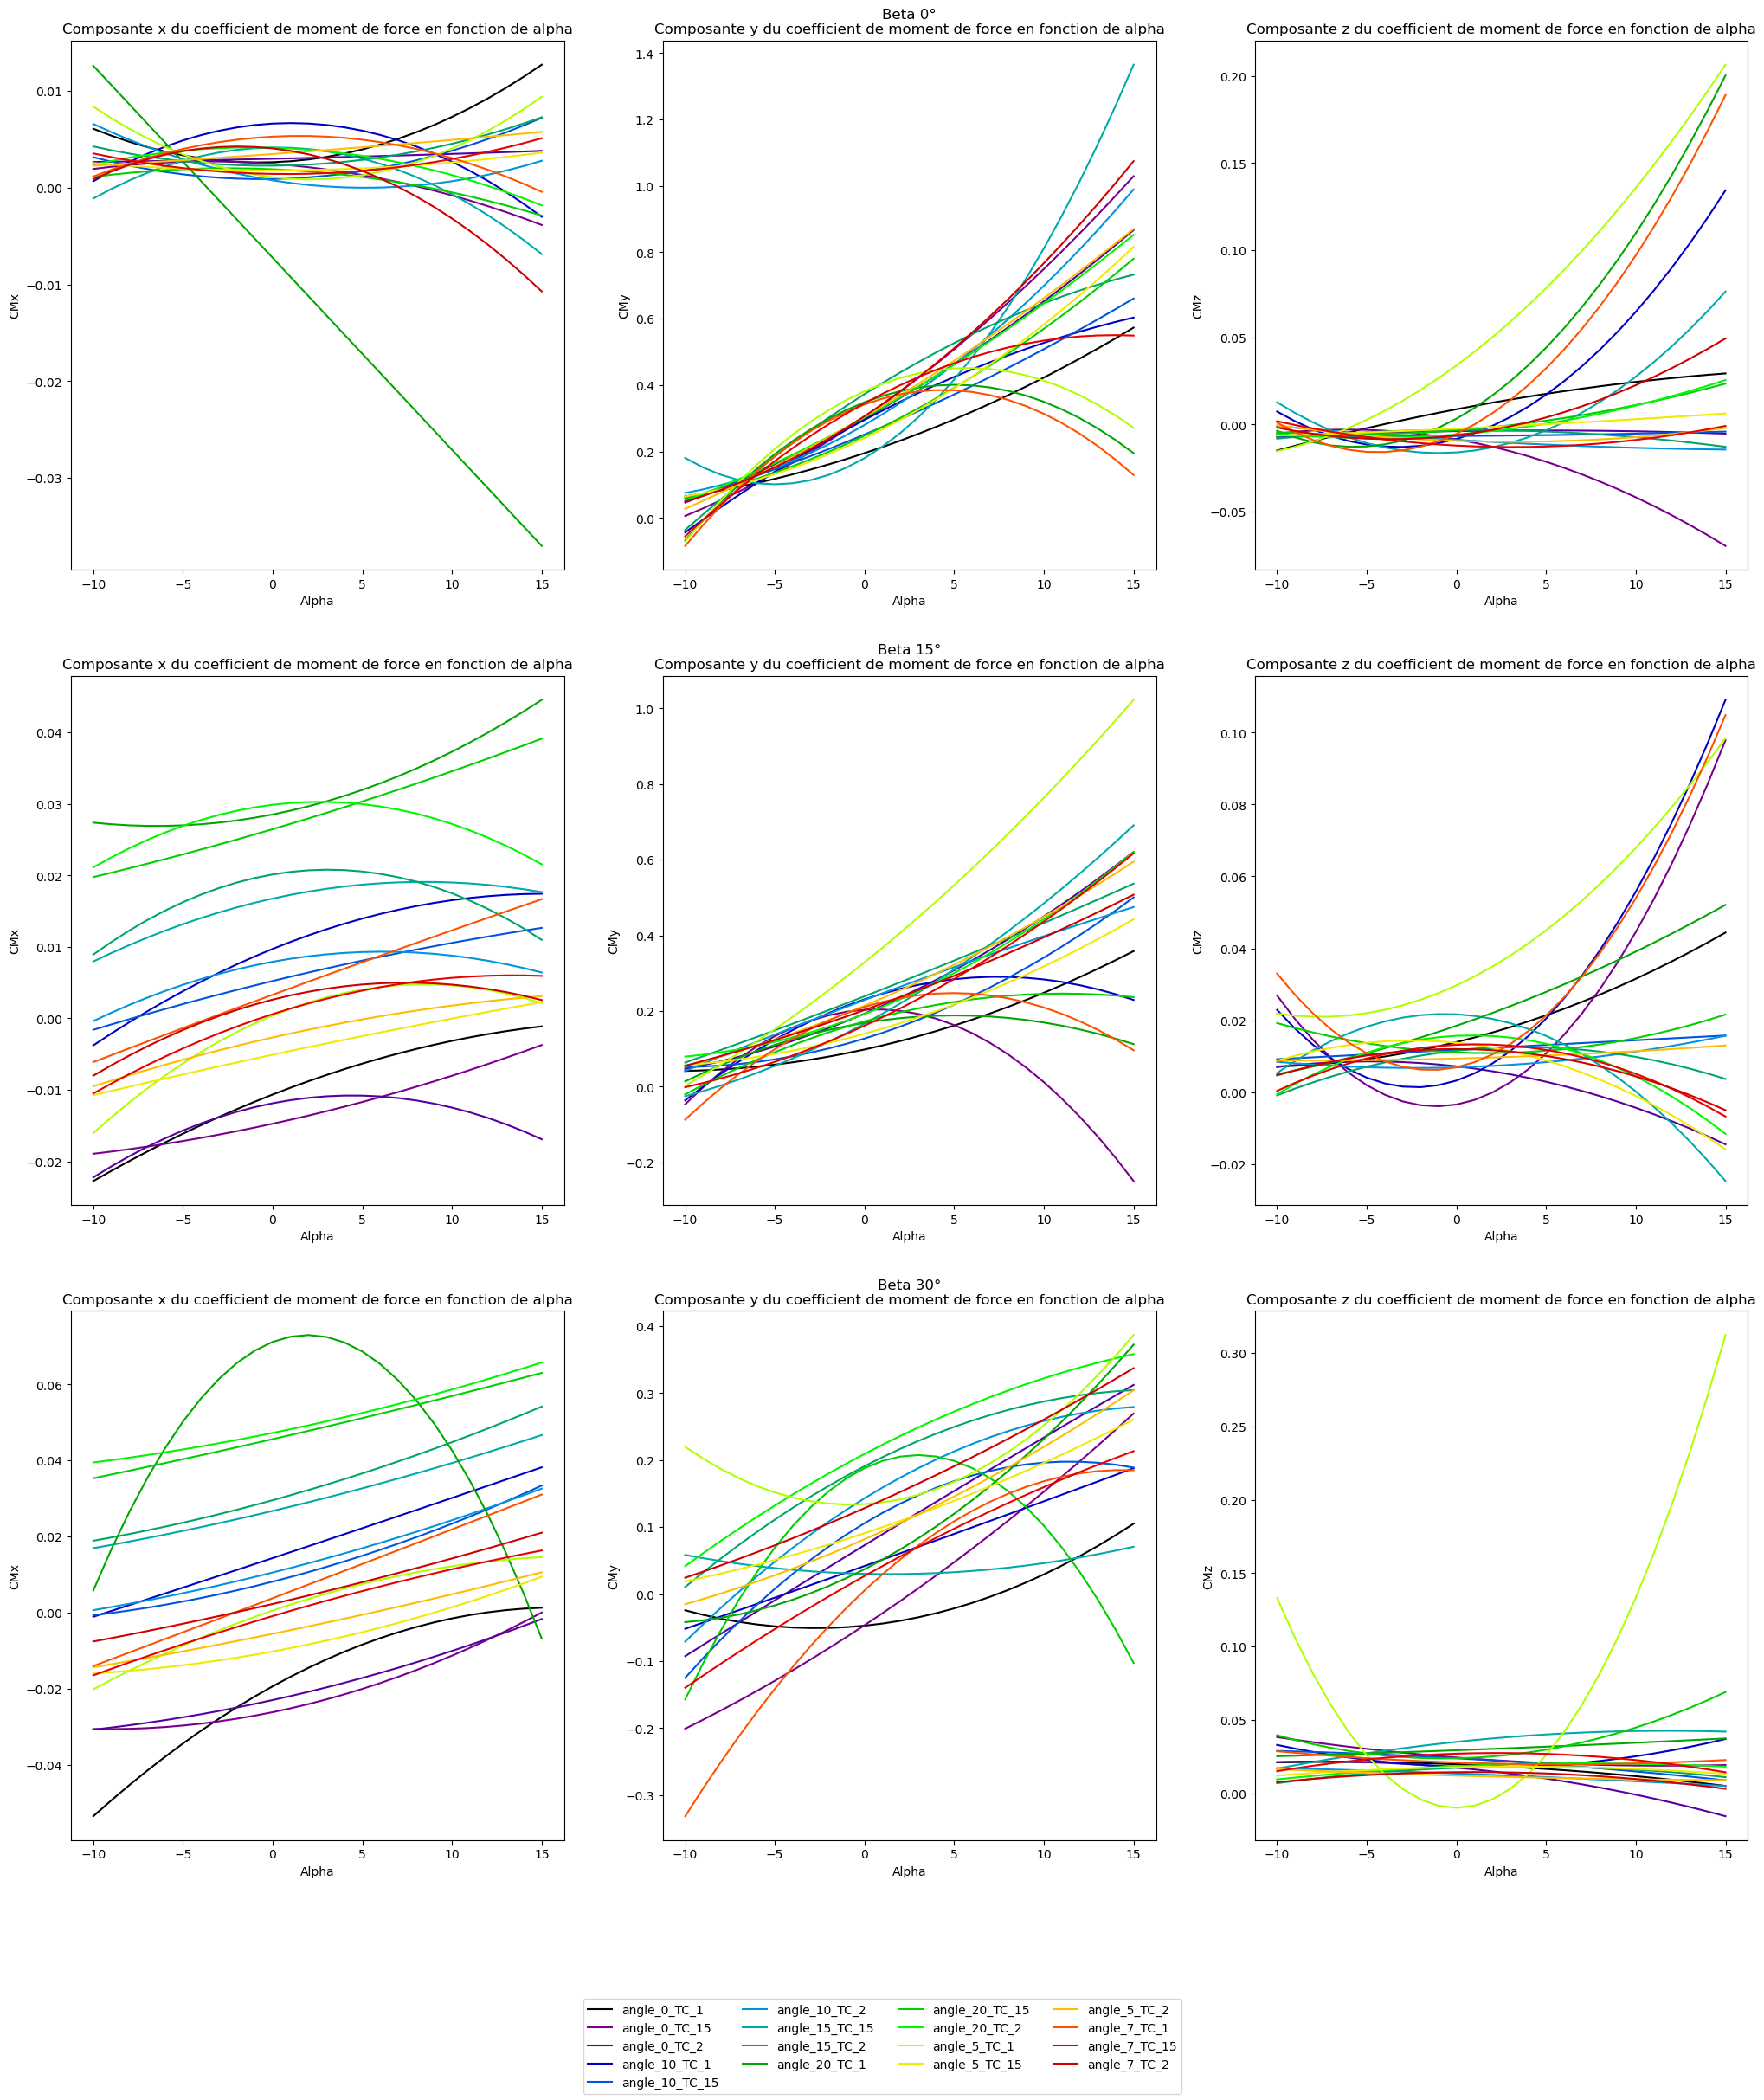

In [37]:

n_beta = 3
n_cols = 3

fig, axes = plt.subplots(n_beta, n_cols, figsize=(25, 9 * n_beta))
models_list = list(next(iter(data.values())).keys())

cmap = plt.get_cmap('nipy_spectral')
colors = [cmap(i / len(models_list)) for i in range(len(models_list))]

for row, (beta, models) in enumerate(data.items()):
    for idx, (model, values) in enumerate(models.items()):
        alphas = np.arange(-10, 16)
        color = colors[models_list.index(model)]
        coefs = np.polyfit(alphas, values["cmx"], 2)
        cmx_fit = np.polyval(coefs, alphas)
        axes[row, 0].plot(alphas, cmx_fit, label=f"{model}", color=color)
        axes[row, 0].set_xlabel("Alpha")
        axes[row, 0].set_ylabel("CMx")

        coefs = np.polyfit(alphas, values["cmy"], 2)
        cmy_fit = np.polyval(coefs, alphas)
        axes[row, 1].plot(alphas, cmy_fit, label=f"{model}", color=color)
        axes[row, 1].set_xlabel("Alpha")
        axes[row, 1].set_ylabel("CMy")

        coefs = np.polyfit(alphas, values["cmz"], 2)
        cmz_fit = np.polyval(coefs, alphas)
        axes[row, 2].plot(alphas, cmz_fit, label=f"{model}", color=color)
        axes[row, 2].set_ylabel("CMz")
        axes[row, 2].set_xlabel("Alpha")
        axes[row, 0].set_title("\nComposante x du coefficient de moment de force en fonction de alpha")
        axes[row, 1].set_title(f"Beta {round(float(beta))}°\nComposante y du coefficient de moment de force en fonction de alpha")
        axes[row, 2].set_title("\nComposante z du coefficient de moment de force en fonction de alpha")


fig.legend(models_list, loc="lower center", ncol=4)
plt.savefig("planche_betas_compcm.png", dpi=700)
plt.show()

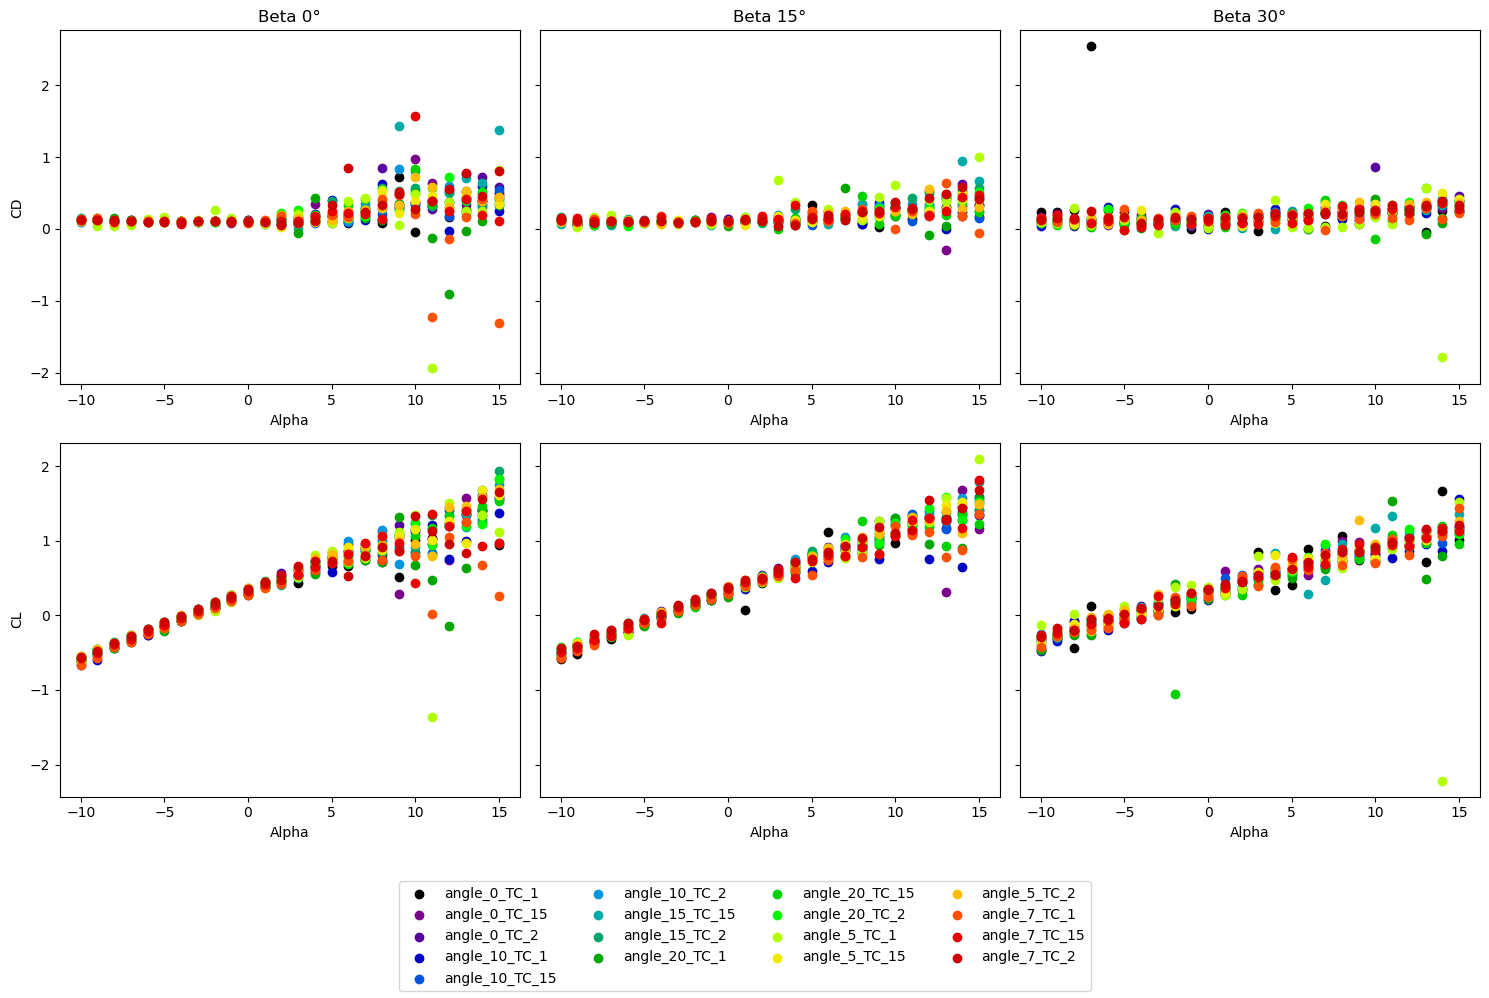

In [29]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharey='row')  # 2 lignes (CD, CL), 3 colonnes (beta)

models_list = list(next(iter(data.values())).keys())

cmap = plt.get_cmap('nipy_spectral')
colors = [cmap(i / len(models_list)) for i in range(len(models_list))]

for col, (beta, models) in enumerate(data.items()):
    # Ligne 0 : CD
    for idx, (model, values) in enumerate(models.items()):
        alphas = np.arange(-10, 16)
        axes[0, col].scatter(alphas, values["cd"], label=model, color=colors[idx])
    axes[0, col].set_xlabel("Alpha")
    axes[0, col].set_title(f"Beta {round(float(beta))}°")
    if col == 0:
        axes[0, col].set_ylabel("CD")
    # Ligne 1 : CL
    for idx, (model, values) in enumerate(models.items()):
        alphas = np.arange(-10, 16)
        axes[1, col].scatter(alphas, values["cl"], label=model, color=colors[idx])
    axes[1, col].set_xlabel("Alpha")
    if col == 0:
        axes[1, col].set_ylabel("CL")

fig.legend(models_list, loc="lower center", ncol=4)
fig.tight_layout(rect=[0, 0.14, 1, 1])  # laisse de la place en bas pour la légende
plt.savefig("planchebetacoeff1.png", dpi=700)
plt.show()